In [1]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

Loading contents from file...


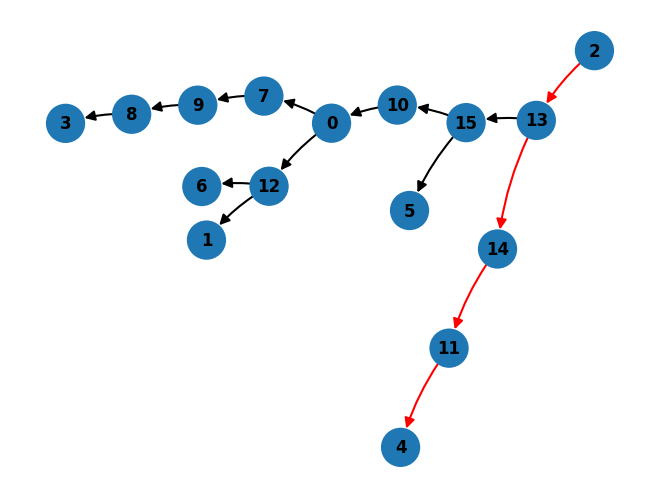

In [2]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

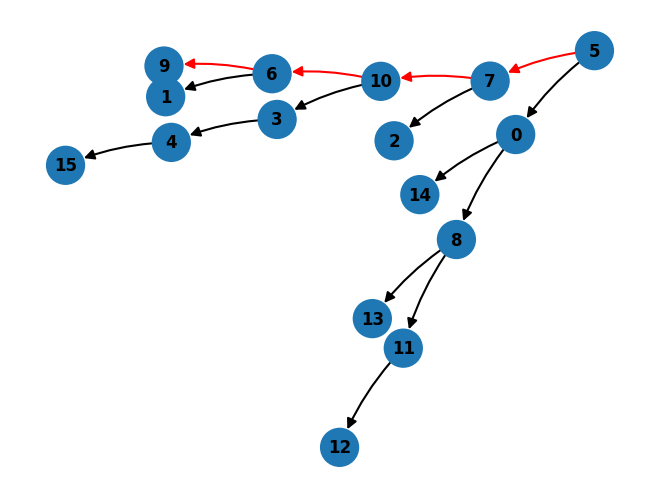

In [4]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = generate_example(n_states, random_seed, order="backward")
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [5]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


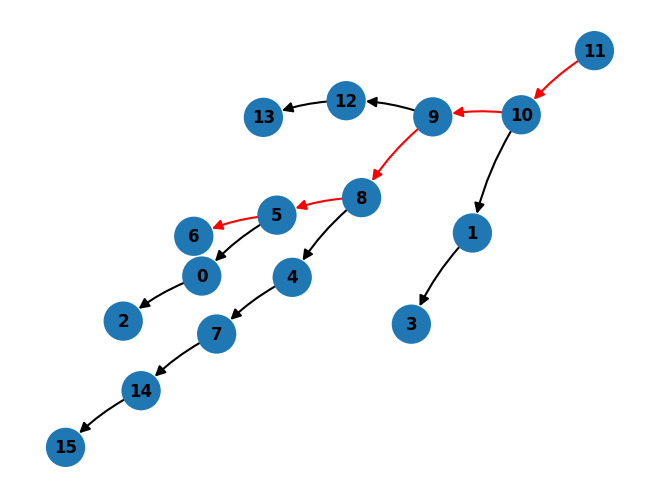

In [6]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = "14>15,0>2,7>14,5>6,5>0,4>7,12>13,8>5,8>4,9>12,9>8,1>3,10>9,10>1,11>10|6:11>10>9>8>5>6"
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [7]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Compare Subpaths to Full Path

In [8]:
def delete_non_paths(input_dict):
    keys_to_delete = [key for key, value in input_dict.items() if len(value) <= 2]
    for key in keys_to_delete:
        del input_dict[key]
    return input_dict

special_chars = [",", ":", "|"]
def get_paths(cache, labels, threshold=0.6):

    paths = {}
    for layer in range(1, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token)
                        else:
                            paths[identifier] = [attended_token, previous_token]
    
    paths = delete_non_paths(paths)
    return paths

In [9]:
def get_paths_all_layers(cache, labels, threshold=0.1,delete_not_paths=True):

    paths = {}
    for layer in range(0, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", " ")
                    previous_token = labels[attended_pos - 1].replace(">", " ")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token+f"_layer{layer}")
                        else:
                            paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    if(delete_not_paths):
        paths = delete_non_paths(paths)
    return paths

In [10]:
def get_attended_pos(cache, labels,positions,layers=range(0,6), threshold=0.1):
    paths = {}
    for layer in layers:
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in positions:       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos]
                    previous_token = labels[attended_pos - 1]
                    identifier = (current_pos, current_token)
                    if identifier in paths.keys():
                        paths[identifier].append(previous_token+f"_layer{layer}")
                    else:
                        paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    return paths

In [11]:
def get_attended_pos_keys(cache, labels,positions,layers=range(0,6), threshold=0.1):
    paths = {}
    for layer in layers:
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in positions:       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    identifier = (current_pos, current_token)
                    if identifier in paths.keys():
                        paths[identifier].append(previous_token)
                    else:
                        paths[identifier] = [attended_token, previous_token]
    return paths

In [12]:
def can_construct_full_path(subpaths, full_path):
    # create a set of edges from the subpaths
    edges = set()
    for subpath in subpaths:
        for i in range(len(subpath) - 1):
            edges.add((subpath[i], subpath[i+1]))

    # create a set of edges required to traverse the full path
    required_edges = set()
    for i in range(len(full_path) - 1):
        required_edges.add((full_path[i], full_path[i+1]))

    # check if all required edges are in the set of edges from the subpaths
    return required_edges.issubset(edges)

['N0_13', 'N1_>14', 'N2_,', 'N3_7', 'N4_>13', 'N5_,', 'N6_7', 'N7_>10', 'N8_,', 'N9_2', 'N10_>7', 'N11_,', 'N12_2', 'N13_>6', 'N14_,', 'N15_5', 'N16_>12', 'N17_,', 'N18_5', 'N19_>2', 'N20_,', 'N21_0', 'N22_>5', 'N23_,', 'N24_15', 'N25_>4', 'N26_,', 'N27_15', 'N28_>0', 'N29_,', 'N30_1', 'N31_>3', 'N32_,', 'N33_11', 'N34_>15', 'N35_,', 'N36_11', 'N37_>1', 'N38_,', 'N39_9', 'N40_>11', 'N41_,', 'N42_8', 'N43_>9', 'N44_|', 'N45_6', 'N46_:', 'N47_8', 'N48_>9', 'N49_>11', 'N50_>15', 'N51_>0', 'N52_>5', 'N53_>2', 'N54_>6', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
13>14,7>13,7>10,2>7,2>6,5>12,5>2,0>5,15>4,15>0,1>3,11>15,11>1,9>11,8>9|6:8>9>11>15>0>5>2>6
atended_pos
{(38, ','): [',_layer0', '>0_layer0', '7_layer1'], (39, '9'): ['13_layer0', ',_layer0', '2_layer1', '0_layer1', '15_layer1'], (42, '8'): ['11_layer0', ',_layer0', '9_layer1'], (36, '11'): ['>5_layer1', '0_layer1', '15_layer1', '11_layer1']}
['N0_13', 'N1_>15', 'N2_,', 'N3_14',

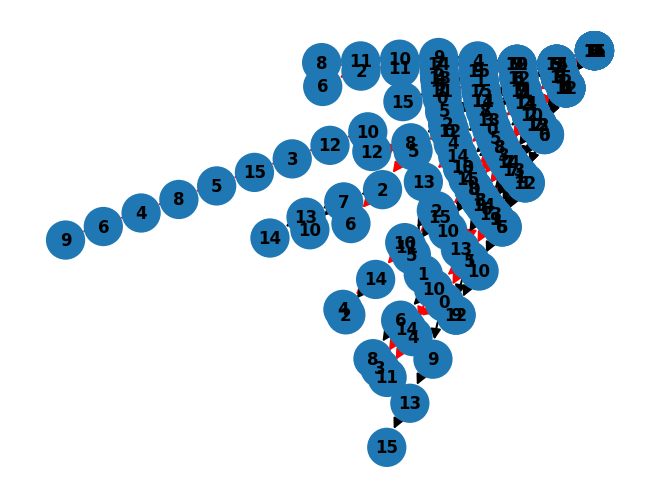

In [13]:
import random
n_examples = 10
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths_all = get_paths_all_layers(cache, labels,threshold=0.05,delete_not_paths=True)
    atended_pos=get_attended_pos(cache, labels,[36,38,39,42],layers=[0,1],threshold=0.1)
    subpaths = get_paths(cache, labels)
    print(graph_numbered)
    print(graph)
    #print(subpaths)
    #print(subpaths_all)
    print("atended_pos")
    print(atended_pos)
    parse_example(graph)


['N0_11', 'N1_>14', 'N2_,', 'N3_7', 'N4_>11', 'N5_,', 'N6_4', 'N7_>7', 'N8_,', 'N9_6', 'N10_>8', 'N11_,', 'N12_3', 'N13_>4', 'N14_,', 'N15_2', 'N16_>6', 'N17_,', 'N18_2', 'N19_>3', 'N20_,', 'N21_0', 'N22_>13', 'N23_,', 'N24_0', 'N25_>2', 'N26_,', 'N27_12', 'N28_>1', 'N29_,', 'N30_12', 'N31_>0', 'N32_,', 'N33_5', 'N34_>15', 'N35_,', 'N36_5', 'N37_>10', 'N38_,', 'N39_9', 'N40_>12', 'N41_,', 'N42_9', 'N43_>5', 'N44_|', 'N45_1', 'N46_:', 'N47_9', 'N48_>12', 'N49_>1', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
11>14,7>11,4>7,6>8,3>4,2>6,2>3,0>13,0>2,12>1,12>0,5>15,5>10,9>12,9>5|1:9>12>1
node position >6 16
node position >12 40
atended_pos_36:{(36, '5'): ['6_layer0', ',_layer0', '2_layer1']}

['N0_2', 'N1_>0', 'N2_,', 'N3_14', 'N4_>2', 'N5_,', 'N6_5', 'N7_>14', 'N8_,', 'N9_11', 'N10_>5', 'N11_,', 'N12_12', 'N13_>11', 'N14_,', 'N15_12', 'N16_>3', 'N17_,', 'N18_10', 'N19_>12', 'N20_,', 'N21_13'

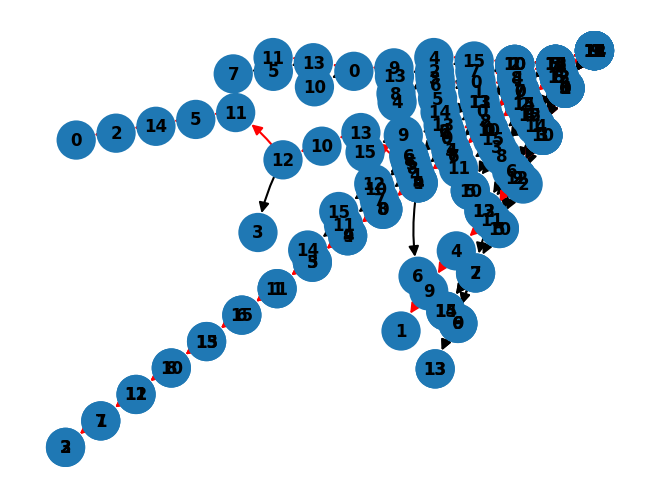

In [14]:

#plotting examples where filtered_position is not there.
node_filter=">6"
node_filter2=">12"#should be a list
import random
n_examples = 10
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    node_position=-1
    for i, component in enumerate(graph_split):
        if dataset.idx2tokens[component] == node_filter:
           node_position = i
           break
    node_position2=-1
    for i, component in enumerate(graph_split):
        if dataset.idx2tokens[component] == node_filter2:
           node_position2 = i
           break    

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths_all = get_paths_all_layers(cache, labels,threshold=0.05,delete_not_paths=True)
    atended_pos=get_attended_pos(cache, labels,[38,39,42],layers=[0,1],threshold=0.1)
    atended_pos_36=get_attended_pos(cache, labels,[36],layers=[0,1],threshold=0.1)
    subpaths = get_paths(cache, labels)
    print(graph_numbered)
    print(graph)
    #print(subpaths)
    #print(subpaths_all)
    print(f"node position >6 {node_position}")
    print(f"node position >12 {node_position2}")
    print(f'atended_pos_36:{atended_pos_36}')
    print("")
    #print(f'atended_pos:{atended_pos}')
    
    parse_example(graph)

In [15]:
def subpath_filtered(n_examples,subpath_position=36,threshold=0.3,subpath_layers_to_print=[1],print_position_token=">6",node_filter="6",not_in_subpath=True):
    for _ in range(n_examples):

        # get example
        random_seed = np.random.randint(1_000_000, 1_000_000_000)
        graph = generate_example(n_states, random_seed, order="backward")
        full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
        full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
        graph_split = dataset.tokenize(graph)
        graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
        node_position=-1
        for i, component in enumerate(graph_split):
            if dataset.idx2tokens[component] == print_position_token:
                node_position = i
                break
        # get cache
        prediction, is_correct = eval_model(model, dataset, graph)
        labels, cache = get_example_cache(prediction, model, dataset)

        # get subpaths and reverse (as the model is backtracking)
        subpaths = get_paths(cache, labels)
        subpaths_filter = get_attended_pos_keys(cache, labels,[subpath_position],layers=[1],threshold=threshold)
        subpaths_print = get_attended_pos_keys(cache, labels,[subpath_position],layers=subpath_layers_to_print,threshold=threshold)
        filter_node=""
        for path in subpaths_filter.values():
            filter_node =path
        if (node_filter in filter_node) ^ not_in_subpath:
            print(f'{print_position_token}_position {node_position}')
            print(f'filter_subpaths={subpaths_print}')
            print(graph_numbered)
            print(graph)
            parse_example(graph)
            plt.show()

>6_position 28
filter_subpaths={(36, '11'): ['3', '1']}
['N0_14', 'N1_>15', 'N2_,', 'N3_7', 'N4_>14', 'N5_,', 'N6_7', 'N7_>12', 'N8_,', 'N9_4', 'N10_>13', 'N11_,', 'N12_4', 'N13_>8', 'N14_,', 'N15_3', 'N16_>7', 'N17_,', 'N18_3', 'N19_>4', 'N20_,', 'N21_1', 'N22_>3', 'N23_,', 'N24_1', 'N25_>2', 'N26_,', 'N27_10', 'N28_>6', 'N29_,', 'N30_10', 'N31_>1', 'N32_,', 'N33_11', 'N34_>10', 'N35_,', 'N36_11', 'N37_>5', 'N38_,', 'N39_9', 'N40_>11', 'N41_,', 'N42_9', 'N43_>0', 'N44_|', 'N45_6', 'N46_:', 'N47_9', 'N48_>11', 'N49_>10', 'N50_>6', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
14>15,7>14,7>12,4>13,4>8,3>7,3>4,1>3,1>2,10>6,10>1,11>10,11>5,9>11,9>0|6:9>11>10>6


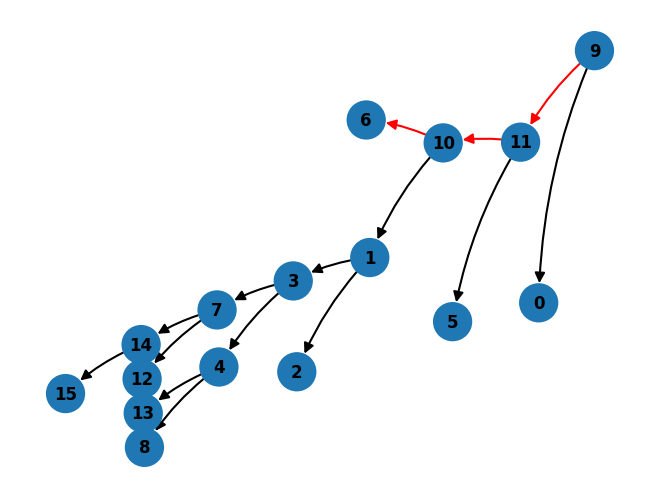

>6_position 16
filter_subpaths={(36, '0'): ['12', '10', '9']}
['N0_12', 'N1_>13', 'N2_,', 'N3_10', 'N4_>12', 'N5_,', 'N6_9', 'N7_>10', 'N8_,', 'N9_7', 'N10_>9', 'N11_,', 'N12_5', 'N13_>7', 'N14_,', 'N15_5', 'N16_>6', 'N17_,', 'N18_4', 'N19_>15', 'N20_,', 'N21_4', 'N22_>5', 'N23_,', 'N24_3', 'N25_>8', 'N26_,', 'N27_1', 'N28_>4', 'N29_,', 'N30_1', 'N31_>3', 'N32_,', 'N33_0', 'N34_>2', 'N35_,', 'N36_0', 'N37_>1', 'N38_,', 'N39_11', 'N40_>14', 'N41_,', 'N42_11', 'N43_>0', 'N44_|', 'N45_14', 'N46_:', 'N47_11', 'N48_>14', 'N49_,', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>13,10>12,9>10,7>9,5>7,5>6,4>15,4>5,3>8,1>4,1>3,0>2,0>1,11>14,11>0|14:11>14


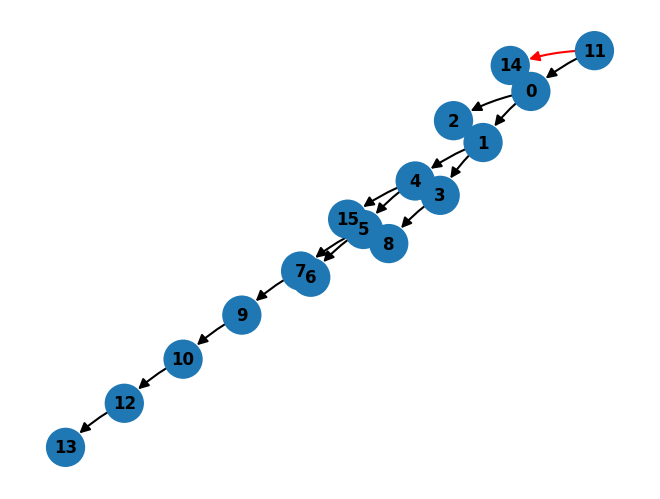

>6_position -1
filter_subpaths={(36, '2'): ['12', '4', '14']}
['N0_3', 'N1_>10', 'N2_,', 'N3_3', 'N4_>1', 'N5_,', 'N6_8', 'N7_>7', 'N8_,', 'N9_8', 'N10_>3', 'N11_,', 'N12_12', 'N13_>13', 'N14_,', 'N15_11', 'N16_>8', 'N17_,', 'N18_4', 'N19_>12', 'N20_,', 'N21_9', 'N22_>15', 'N23_,', 'N24_14', 'N25_>11', 'N26_,', 'N27_14', 'N28_>4', 'N29_,', 'N30_5', 'N31_>9', 'N32_,', 'N33_2', 'N34_>14', 'N35_,', 'N36_2', 'N37_>0', 'N38_,', 'N39_6', 'N40_>5', 'N41_,', 'N42_6', 'N43_>2', 'N44_|', 'N45_10', 'N46_:', 'N47_6', 'N48_>2', 'N49_>14', 'N50_>11', 'N51_>8', 'N52_>3', 'N53_>10', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
3>10,3>1,8>7,8>3,12>13,11>8,4>12,9>15,14>11,14>4,5>9,2>14,2>0,6>5,6>2|10:6>2>14>11>8>3>10


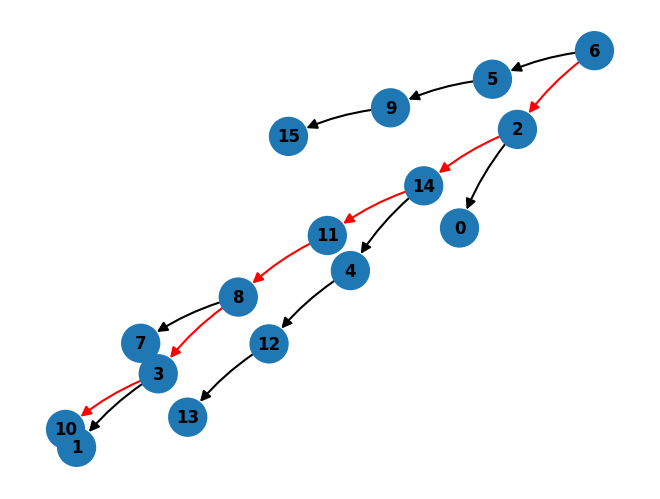

>6_position 13
filter_subpaths={(36, '1'): ['12', '2']}
['N0_7', 'N1_>14', 'N2_,', 'N3_5', 'N4_>15', 'N5_,', 'N6_5', 'N7_>7', 'N8_,', 'N9_9', 'N10_>11', 'N11_,', 'N12_9', 'N13_>6', 'N14_,', 'N15_4', 'N16_>5', 'N17_,', 'N18_10', 'N19_>13', 'N20_,', 'N21_12', 'N22_>9', 'N23_,', 'N24_12', 'N25_>4', 'N26_,', 'N27_8', 'N28_>10', 'N29_,', 'N30_2', 'N31_>12', 'N32_,', 'N33_2', 'N34_>0', 'N35_,', 'N36_1', 'N37_>8', 'N38_,', 'N39_3', 'N40_>2', 'N41_,', 'N42_3', 'N43_>1', 'N44_|', 'N45_6', 'N46_:', 'N47_3', 'N48_>2', 'N49_>12', 'N50_>9', 'N51_>6', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
7>14,5>15,5>7,9>11,9>6,4>5,10>13,12>9,12>4,8>10,2>12,2>0,1>8,3>2,3>1|6:3>2>12>9>6


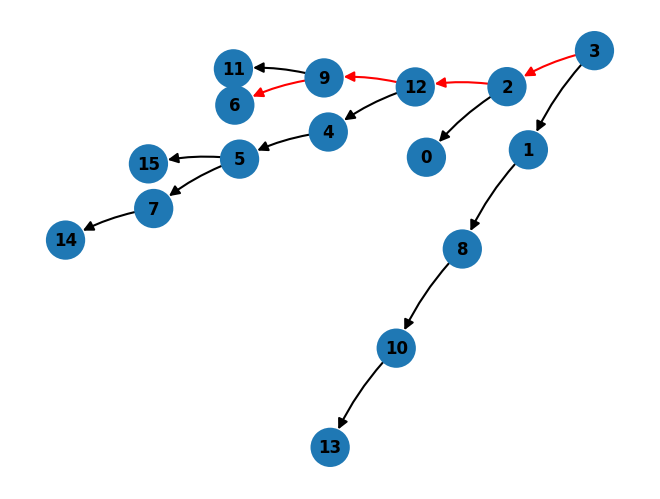

>6_position 40
filter_subpaths={}
['N0_15', 'N1_>9', 'N2_,', 'N3_8', 'N4_>15', 'N5_,', 'N6_11', 'N7_>8', 'N8_,', 'N9_12', 'N10_>11', 'N11_,', 'N12_0', 'N13_>12', 'N14_,', 'N15_5', 'N16_>0', 'N17_,', 'N18_10', 'N19_>14', 'N20_,', 'N21_10', 'N22_>5', 'N23_,', 'N24_13', 'N25_>10', 'N26_,', 'N27_1', 'N28_>13', 'N29_,', 'N30_4', 'N31_>1', 'N32_,', 'N33_3', 'N34_>4', 'N35_,', 'N36_6', 'N37_>3', 'N38_,', 'N39_2', 'N40_>6', 'N41_,', 'N42_7', 'N43_>2', 'N44_|', 'N45_9', 'N46_:', 'N47_7', 'N48_>2', 'N49_>6', 'N50_>3', 'N51_>4', 'N52_>1', 'N53_>13', 'N54_>10', 'N55_>5', 'N56_>0', 'N57_>12', 'N58_>11', 'N59_>8', 'N60_>15', 'N61_>9', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
15>9,8>15,11>8,12>11,0>12,5>0,10>14,10>5,13>10,1>13,4>1,3>4,6>3,2>6,7>2|9:7>2>6>3>4>1>13>10>5>0>12>11>8>15>9


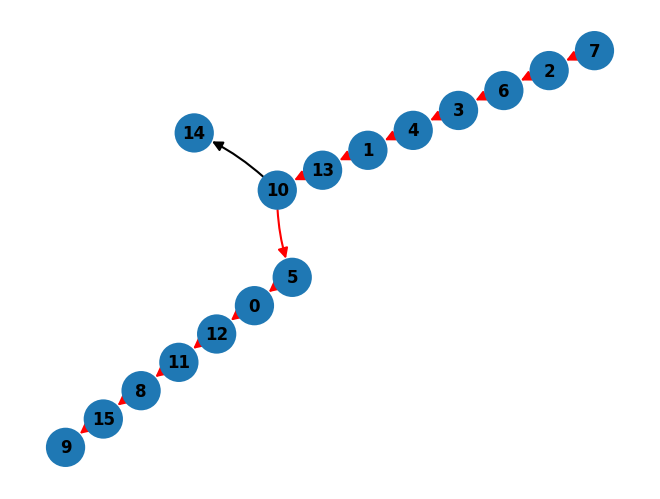

>6_position 43
filter_subpaths={(36, '14'): ['0', '10', '4', '12']}
['N0_5', 'N1_>7', 'N2_,', 'N3_0', 'N4_>11', 'N5_,', 'N6_0', 'N7_>5', 'N8_,', 'N9_10', 'N10_>9', 'N11_,', 'N12_10', 'N13_>0', 'N14_,', 'N15_1', 'N16_>13', 'N17_,', 'N18_12', 'N19_>10', 'N20_,', 'N21_12', 'N22_>1', 'N23_,', 'N24_4', 'N25_>12', 'N26_,', 'N27_15', 'N28_>4', 'N29_,', 'N30_15', 'N31_>3', 'N32_,', 'N33_14', 'N34_>15', 'N35_,', 'N36_14', 'N37_>8', 'N38_,', 'N39_2', 'N40_>14', 'N41_,', 'N42_2', 'N43_>6', 'N44_|', 'N45_7', 'N46_:', 'N47_2', 'N48_>14', 'N49_>15', 'N50_>4', 'N51_>12', 'N52_>10', 'N53_>0', 'N54_>5', 'N55_>7', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
5>7,0>11,0>5,10>9,10>0,1>13,12>10,12>1,4>12,15>4,15>3,14>15,14>8,2>14,2>6|7:2>14>15>4>12>10>0>5>7


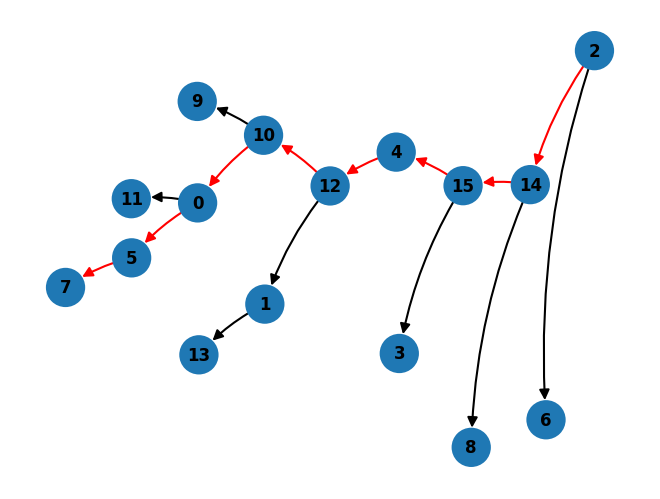

In [16]:
subpath_filtered(10,subpath_position=36,print_position_token=">6",node_filter="6",not_in_subpath=True,subpath_layers_to_print=[1,2])

>10_position -1
filter_subpaths={(38, ','): [',', '5']}
['N0_8', 'N1_>13', 'N2_,', 'N3_0', 'N4_>8', 'N5_,', 'N6_14', 'N7_>0', 'N8_,', 'N9_15', 'N10_>14', 'N11_,', 'N12_12', 'N13_>15', 'N14_,', 'N15_7', 'N16_>12', 'N17_,', 'N18_1', 'N19_>7', 'N20_,', 'N21_2', 'N22_>1', 'N23_,', 'N24_9', 'N25_>2', 'N26_,', 'N27_4', 'N28_>9', 'N29_,', 'N30_11', 'N31_>4', 'N32_,', 'N33_5', 'N34_>11', 'N35_,', 'N36_3', 'N37_>5', 'N38_,', 'N39_6', 'N40_>3', 'N41_,', 'N42_10', 'N43_>6', 'N44_|', 'N45_13', 'N46_:', 'N47_10', 'N48_>6', 'N49_>3', 'N50_>5', 'N51_>11', 'N52_>4', 'N53_>9', 'N54_>2', 'N55_>1', 'N56_>7', 'N57_>12', 'N58_>15', 'N59_>14', 'N60_>0', 'N61_>8', 'N62_>13', 'N63_,', 'N64_,', 'N65_,']
8>13,0>8,14>0,15>14,12>15,7>12,1>7,2>1,9>2,4>9,11>4,5>11,3>5,6>3,10>6|13:10>6>3>5>11>4>9>2>1>7>12>15>14>0>8>13


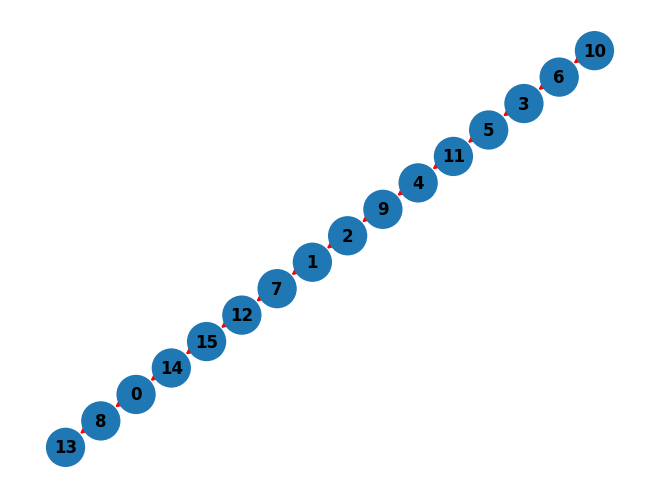

>10_position -1
filter_subpaths={(38, ','): [',', '0']}
['N0_12', 'N1_>15', 'N2_,', 'N3_11', 'N4_>12', 'N5_,', 'N6_5', 'N7_>11', 'N8_,', 'N9_3', 'N10_>6', 'N11_,', 'N12_4', 'N13_>5', 'N14_,', 'N15_14', 'N16_>3', 'N17_,', 'N18_2', 'N19_>9', 'N20_,', 'N21_2', 'N22_>4', 'N23_,', 'N24_1', 'N25_>14', 'N26_,', 'N27_13', 'N28_>2', 'N29_,', 'N30_13', 'N31_>1', 'N32_,', 'N33_8', 'N34_>13', 'N35_,', 'N36_8', 'N37_>0', 'N38_,', 'N39_7', 'N40_>8', 'N41_,', 'N42_10', 'N43_>7', 'N44_|', 'N45_6', 'N46_:', 'N47_10', 'N48_>7', 'N49_>8', 'N50_>13', 'N51_>1', 'N52_>14', 'N53_>3', 'N54_>6', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>15,11>12,5>11,3>6,4>5,14>3,2>9,2>4,1>14,13>2,13>1,8>13,8>0,7>8,10>7|6:10>7>8>13>1>14>3>6


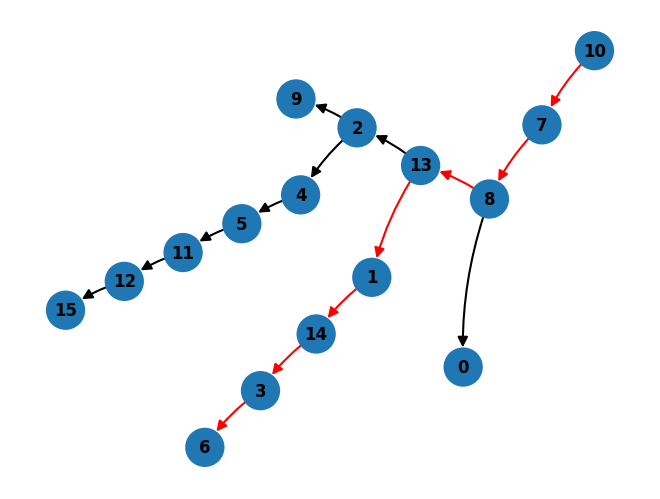

In [17]:
subpath_filtered(20,subpath_position=38,print_position_token=">10",node_filter="10",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

>3_position -1
filter_subpaths={}
['N0_15', 'N1_>13', 'N2_,', 'N3_2', 'N4_>15', 'N5_,', 'N6_6', 'N7_>2', 'N8_,', 'N9_4', 'N10_>6', 'N11_,', 'N12_7', 'N13_>4', 'N14_,', 'N15_10', 'N16_>7', 'N17_,', 'N18_9', 'N19_>10', 'N20_,', 'N21_0', 'N22_>11', 'N23_,', 'N24_0', 'N25_>9', 'N26_,', 'N27_5', 'N28_>0', 'N29_,', 'N30_1', 'N31_>12', 'N32_,', 'N33_8', 'N34_>5', 'N35_,', 'N36_8', 'N37_>1', 'N38_,', 'N39_3', 'N40_>14', 'N41_,', 'N42_3', 'N43_>8', 'N44_|', 'N45_13', 'N46_:', 'N47_3', 'N48_>8', 'N49_>5', 'N50_>0', 'N51_>9', 'N52_>10', 'N53_>7', 'N54_>4', 'N55_>6', 'N56_>2', 'N57_>15', 'N58_>13', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
15>13,2>15,6>2,4>6,7>4,10>7,9>10,0>11,0>9,5>0,1>12,8>5,8>1,3>14,3>8|13:3>8>5>0>9>10>7>4>6>2>15>13


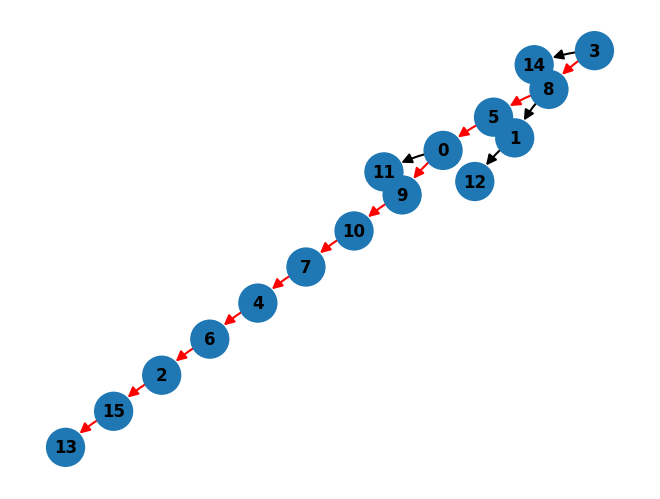

>3_position 31
filter_subpaths={(39, '7'): ['0', '13', '8']}
['N0_4', 'N1_>15', 'N2_,', 'N3_4', 'N4_>9', 'N5_,', 'N6_1', 'N7_>5', 'N8_,', 'N9_10', 'N10_>11', 'N11_,', 'N12_0', 'N13_>4', 'N14_,', 'N15_0', 'N16_>1', 'N17_,', 'N18_6', 'N19_>10', 'N20_,', 'N21_13', 'N22_>14', 'N23_,', 'N24_13', 'N25_>0', 'N26_,', 'N27_2', 'N28_>6', 'N29_,', 'N30_2', 'N31_>3', 'N32_,', 'N33_8', 'N34_>13', 'N35_,', 'N36_8', 'N37_>2', 'N38_,', 'N39_7', 'N40_>12', 'N41_,', 'N42_7', 'N43_>8', 'N44_|', 'N45_14', 'N46_:', 'N47_7', 'N48_>8', 'N49_>13', 'N50_>14', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
4>15,4>9,1>5,10>11,0>4,0>1,6>10,13>14,13>0,2>6,2>3,8>13,8>2,7>12,7>8|14:7>8>13>14


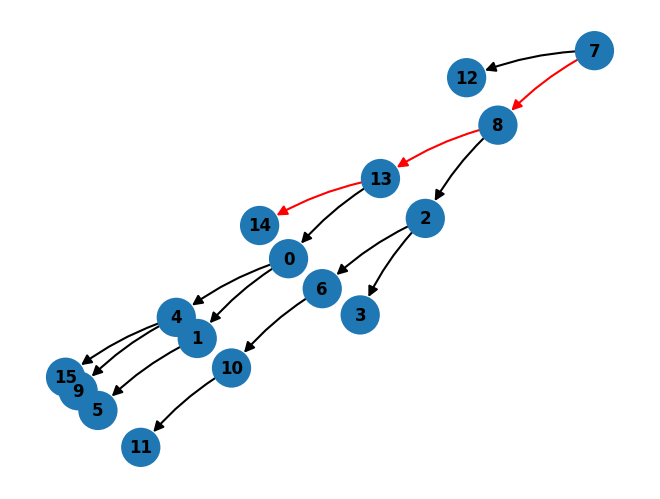

>3_position -1
filter_subpaths={}
['N0_9', 'N1_>12', 'N2_,', 'N3_1', 'N4_>10', 'N5_,', 'N6_1', 'N7_>9', 'N8_,', 'N9_6', 'N10_>13', 'N11_,', 'N12_6', 'N13_>1', 'N14_,', 'N15_5', 'N16_>6', 'N17_,', 'N18_0', 'N19_>5', 'N20_,', 'N21_7', 'N22_>11', 'N23_,', 'N24_7', 'N25_>0', 'N26_,', 'N27_4', 'N28_>15', 'N29_,', 'N30_4', 'N31_>14', 'N32_,', 'N33_8', 'N34_>7', 'N35_,', 'N36_2', 'N37_>4', 'N38_,', 'N39_3', 'N40_>8', 'N41_,', 'N42_3', 'N43_>2', 'N44_|', 'N45_13', 'N46_:', 'N47_3', 'N48_>8', 'N49_>7', 'N50_>0', 'N51_>5', 'N52_>6', 'N53_>13', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
9>12,1>10,1>9,6>13,6>1,5>6,0>5,7>11,7>0,4>15,4>14,8>7,2>4,3>8,3>2|13:3>8>7>0>5>6>13


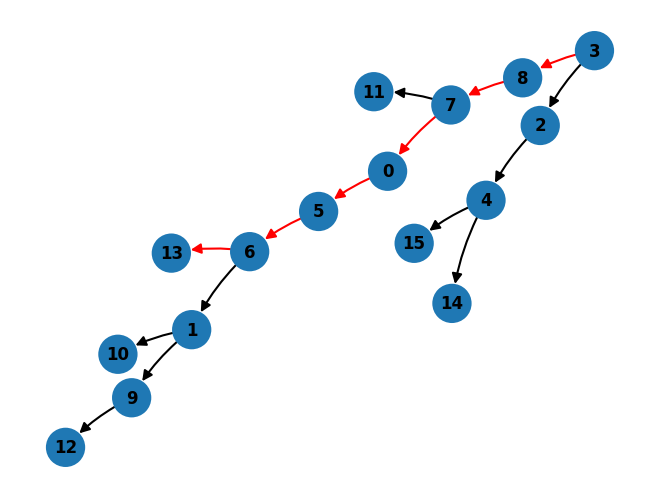

>3_position 4
filter_subpaths={(39, '7'): ['12', '15', '14', '6']}
['N0_12', 'N1_>4', 'N2_,', 'N3_12', 'N4_>3', 'N5_,', 'N6_15', 'N7_>12', 'N8_,', 'N9_9', 'N10_>11', 'N11_,', 'N12_9', 'N13_>10', 'N14_,', 'N15_14', 'N16_>15', 'N17_,', 'N18_5', 'N19_>9', 'N20_,', 'N21_6', 'N22_>14', 'N23_,', 'N24_6', 'N25_>5', 'N26_,', 'N27_1', 'N28_>2', 'N29_,', 'N30_13', 'N31_>6', 'N32_,', 'N33_13', 'N34_>1', 'N35_,', 'N36_0', 'N37_>8', 'N38_,', 'N39_7', 'N40_>13', 'N41_,', 'N42_7', 'N43_>0', 'N44_|', 'N45_3', 'N46_:', 'N47_7', 'N48_>13', 'N49_>6', 'N50_>14', 'N51_>15', 'N52_>12', 'N53_>3', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>4,12>3,15>12,9>11,9>10,14>15,5>9,6>14,6>5,1>2,13>6,13>1,0>8,7>13,7>0|3:7>13>6>14>15>12>3


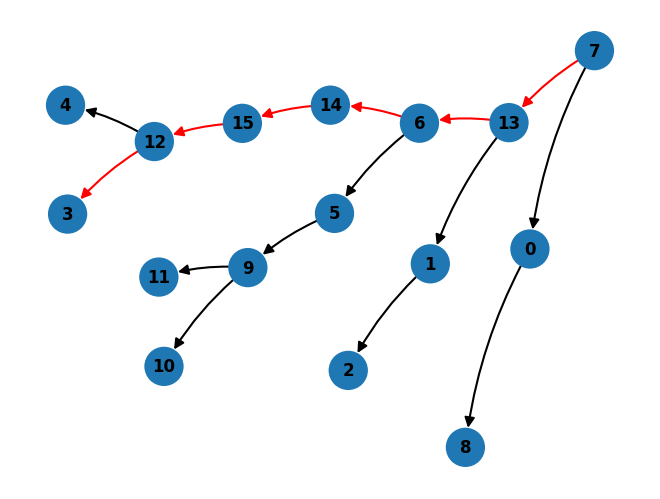

>3_position 1
filter_subpaths={(39, '12'): ['0', '9', '1']}
['N0_2', 'N1_>3', 'N2_,', 'N3_8', 'N4_>14', 'N5_,', 'N6_6', 'N7_>13', 'N8_,', 'N9_6', 'N10_>10', 'N11_,', 'N12_0', 'N13_>15', 'N14_,', 'N15_0', 'N16_>2', 'N17_,', 'N18_5', 'N19_>8', 'N20_,', 'N21_5', 'N22_>7', 'N23_,', 'N24_4', 'N25_>6', 'N26_,', 'N27_9', 'N28_>11', 'N29_,', 'N30_9', 'N31_>0', 'N32_,', 'N33_1', 'N34_>5', 'N35_,', 'N36_1', 'N37_>4', 'N38_,', 'N39_12', 'N40_>9', 'N41_,', 'N42_12', 'N43_>1', 'N44_|', 'N45_11', 'N46_:', 'N47_12', 'N48_>9', 'N49_>11', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
2>3,8>14,6>13,6>10,0>15,0>2,5>8,5>7,4>6,9>11,9>0,1>5,1>4,12>9,12>1|11:12>9>11


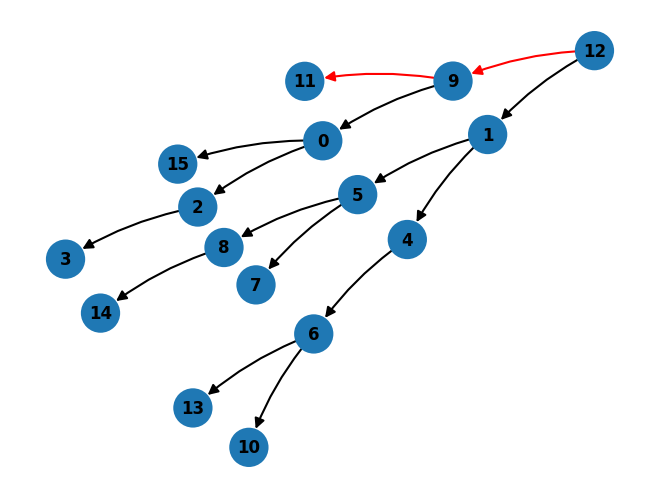

>3_position 43
filter_subpaths={}
['N0_4', 'N1_>12', 'N2_,', 'N3_4', 'N4_>5', 'N5_,', 'N6_11', 'N7_>4', 'N8_,', 'N9_8', 'N10_>11', 'N11_,', 'N12_6', 'N13_>8', 'N14_,', 'N15_1', 'N16_>6', 'N17_,', 'N18_14', 'N19_>7', 'N20_,', 'N21_14', 'N22_>1', 'N23_,', 'N24_0', 'N25_>14', 'N26_,', 'N27_2', 'N28_>10', 'N29_,', 'N30_2', 'N31_>0', 'N32_,', 'N33_13', 'N34_>2', 'N35_,', 'N36_9', 'N37_>13', 'N38_,', 'N39_3', 'N40_>9', 'N41_,', 'N42_15', 'N43_>3', 'N44_|', 'N45_12', 'N46_:', 'N47_15', 'N48_>3', 'N49_>9', 'N50_>13', 'N51_>2', 'N52_>0', 'N53_>14', 'N54_>1', 'N55_>6', 'N56_>8', 'N57_>11', 'N58_>4', 'N59_>12', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
4>12,4>5,11>4,8>11,6>8,1>6,14>7,14>1,0>14,2>10,2>0,13>2,9>13,3>9,15>3|12:15>3>9>13>2>0>14>1>6>8>11>4>12


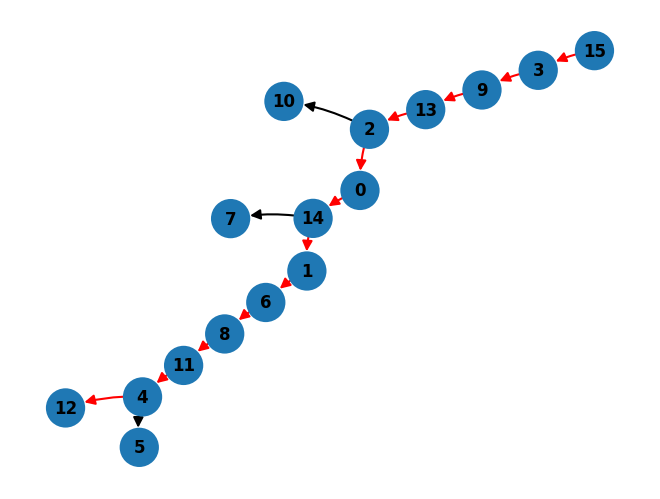

>3_position 40
filter_subpaths={}
['N0_13', 'N1_>8', 'N2_,', 'N3_10', 'N4_>13', 'N5_,', 'N6_4', 'N7_>10', 'N8_,', 'N9_6', 'N10_>4', 'N11_,', 'N12_12', 'N13_>6', 'N14_,', 'N15_0', 'N16_>12', 'N17_,', 'N18_9', 'N19_>0', 'N20_,', 'N21_11', 'N22_>9', 'N23_,', 'N24_2', 'N25_>11', 'N26_,', 'N27_5', 'N28_>2', 'N29_,', 'N30_14', 'N31_>5', 'N32_,', 'N33_15', 'N34_>14', 'N35_,', 'N36_3', 'N37_>15', 'N38_,', 'N39_1', 'N40_>3', 'N41_,', 'N42_7', 'N43_>1', 'N44_|', 'N45_8', 'N46_:', 'N47_7', 'N48_>1', 'N49_>3', 'N50_>15', 'N51_>14', 'N52_>5', 'N53_>2', 'N54_>11', 'N55_>9', 'N56_>0', 'N57_>12', 'N58_>6', 'N59_>4', 'N60_>10', 'N61_>13', 'N62_>8', 'N63_,', 'N64_,', 'N65_,']
13>8,10>13,4>10,6>4,12>6,0>12,9>0,11>9,2>11,5>2,14>5,15>14,3>15,1>3,7>1|8:7>1>3>15>14>5>2>11>9>0>12>6>4>10>13>8


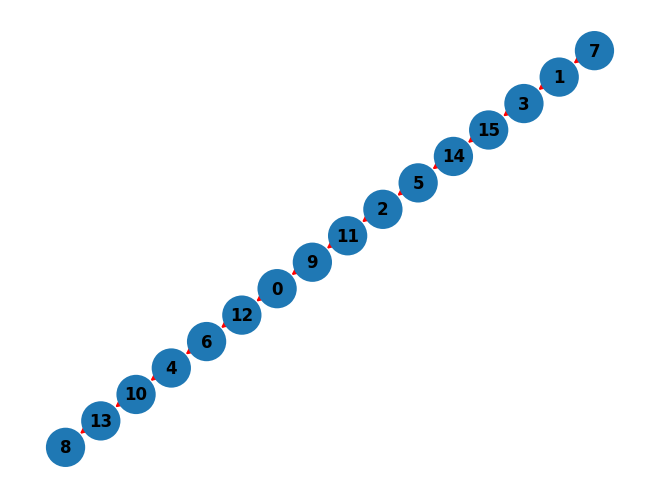

>3_position 40
filter_subpaths={}
['N0_14', 'N1_>15', 'N2_,', 'N3_13', 'N4_>7', 'N5_,', 'N6_13', 'N7_>4', 'N8_,', 'N9_2', 'N10_>14', 'N11_,', 'N12_10', 'N13_>13', 'N14_,', 'N15_10', 'N16_>2', 'N17_,', 'N18_5', 'N19_>10', 'N20_,', 'N21_11', 'N22_>5', 'N23_,', 'N24_0', 'N25_>9', 'N26_,', 'N27_6', 'N28_>11', 'N29_,', 'N30_6', 'N31_>0', 'N32_,', 'N33_3', 'N34_>8', 'N35_,', 'N36_3', 'N37_>6', 'N38_,', 'N39_12', 'N40_>3', 'N41_,', 'N42_1', 'N43_>12', 'N44_|', 'N45_4', 'N46_:', 'N47_1', 'N48_>12', 'N49_>3', 'N50_>6', 'N51_>11', 'N52_>5', 'N53_>10', 'N54_>13', 'N55_>4', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
14>15,13>7,13>4,2>14,10>13,10>2,5>10,11>5,0>9,6>11,6>0,3>8,3>6,12>3,1>12|4:1>12>3>6>11>5>10>13>4


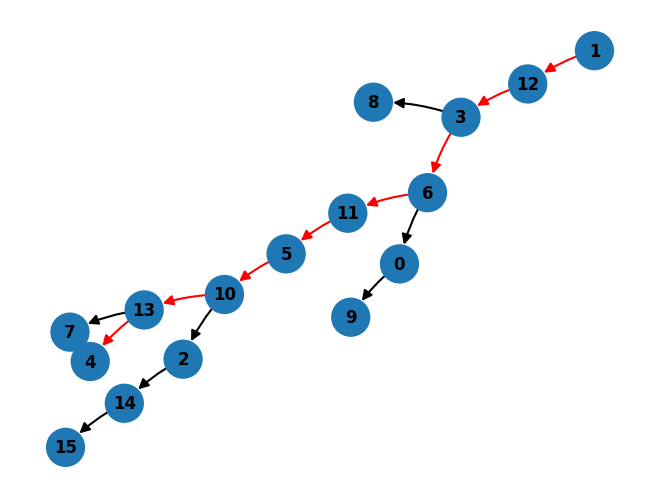

>3_position -1
filter_subpaths={}
['N0_4', 'N1_>11', 'N2_,', 'N3_4', 'N4_>9', 'N5_,', 'N6_5', 'N7_>6', 'N8_,', 'N9_5', 'N10_>4', 'N11_,', 'N12_0', 'N13_>14', 'N14_,', 'N15_0', 'N16_>5', 'N17_,', 'N18_12', 'N19_>10', 'N20_,', 'N21_12', 'N22_>0', 'N23_,', 'N24_13', 'N25_>12', 'N26_,', 'N27_15', 'N28_>13', 'N29_,', 'N30_2', 'N31_>8', 'N32_,', 'N33_7', 'N34_>15', 'N35_,', 'N36_7', 'N37_>2', 'N38_,', 'N39_3', 'N40_>7', 'N41_,', 'N42_3', 'N43_>1', 'N44_|', 'N45_6', 'N46_:', 'N47_3', 'N48_>7', 'N49_>15', 'N50_>13', 'N51_>12', 'N52_>0', 'N53_>5', 'N54_>6', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
4>11,4>9,5>6,5>4,0>14,0>5,12>10,12>0,13>12,15>13,2>8,7>15,7>2,3>7,3>1|6:3>7>15>13>12>0>5>6


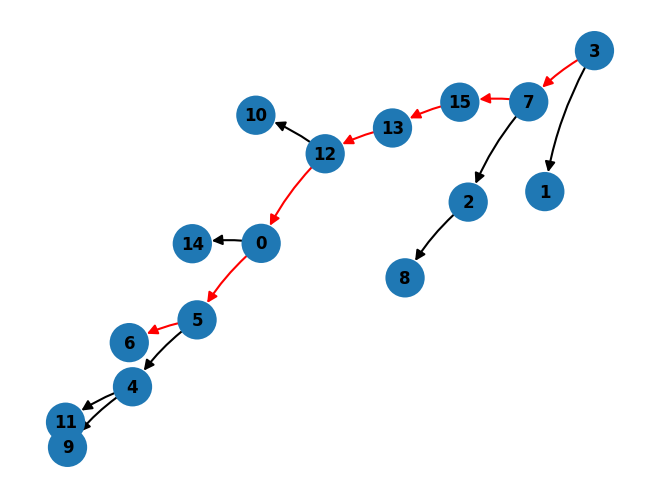

In [18]:
subpath_filtered(20,subpath_position=39,print_position_token=">3",node_filter="3",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

>2_position -1
filter_subpaths={(41, ','): ['0', '6', '11', '3']}
['N0_0', 'N1_>13', 'N2_,', 'N3_6', 'N4_>0', 'N5_,', 'N6_11', 'N7_>6', 'N8_,', 'N9_3', 'N10_>11', 'N11_,', 'N12_5', 'N13_>3', 'N14_,', 'N15_12', 'N16_>15', 'N17_,', 'N18_10', 'N19_>5', 'N20_,', 'N21_9', 'N22_>12', 'N23_,', 'N24_1', 'N25_>10', 'N26_,', 'N27_1', 'N28_>9', 'N29_,', 'N30_4', 'N31_>1', 'N32_,', 'N33_14', 'N34_>4', 'N35_,', 'N36_8', 'N37_>14', 'N38_,', 'N39_7', 'N40_>8', 'N41_,', 'N42_2', 'N43_>7', 'N44_|', 'N45_13', 'N46_:', 'N47_2', 'N48_>7', 'N49_>8', 'N50_>14', 'N51_>4', 'N52_>1', 'N53_>10', 'N54_>5', 'N55_>3', 'N56_>11', 'N57_>6', 'N58_>0', 'N59_>13', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
0>13,6>0,11>6,3>11,5>3,12>15,10>5,9>12,1>10,1>9,4>1,14>4,8>14,7>8,2>7|13:2>7>8>14>4>1>10>5>3>11>6>0>13


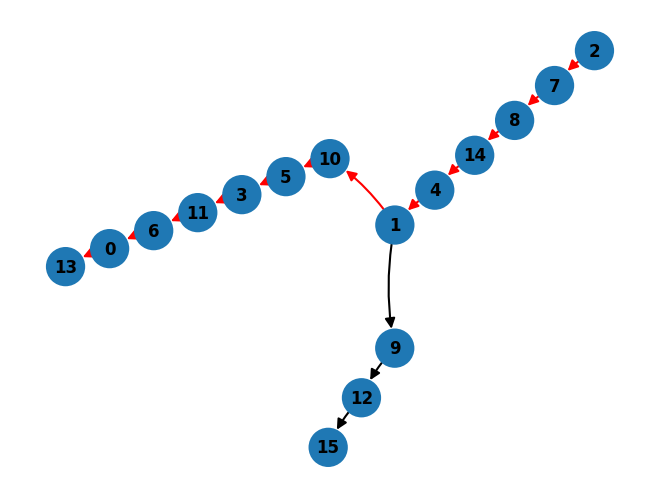

>2_position -1
filter_subpaths={(41, ','): ['0', '8', '5', '10']}
['N0_9', 'N1_>11', 'N2_,', 'N3_7', 'N4_>9', 'N5_,', 'N6_6', 'N7_>14', 'N8_,', 'N9_6', 'N10_>7', 'N11_,', 'N12_0', 'N13_>6', 'N14_,', 'N15_8', 'N16_>4', 'N17_,', 'N18_8', 'N19_>0', 'N20_,', 'N21_1', 'N22_>12', 'N23_,', 'N24_5', 'N25_>8', 'N26_,', 'N27_5', 'N28_>1', 'N29_,', 'N30_10', 'N31_>15', 'N32_,', 'N33_10', 'N34_>5', 'N35_,', 'N36_3', 'N37_>13', 'N38_,', 'N39_3', 'N40_>10', 'N41_,', 'N42_2', 'N43_>3', 'N44_|', 'N45_14', 'N46_:', 'N47_2', 'N48_>3', 'N49_>10', 'N50_>5', 'N51_>8', 'N52_>0', 'N53_>6', 'N54_>14', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
9>11,7>9,6>14,6>7,0>6,8>4,8>0,1>12,5>8,5>1,10>15,10>5,3>13,3>10,2>3|14:2>3>10>5>8>0>6>14


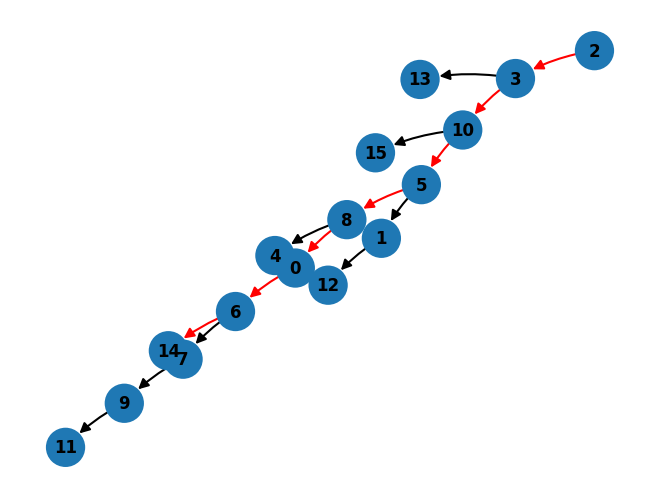

>2_position 43
filter_subpaths={}
['N0_8', 'N1_>13', 'N2_,', 'N3_4', 'N4_>9', 'N5_,', 'N6_3', 'N7_>10', 'N8_,', 'N9_3', 'N10_>8', 'N11_,', 'N12_1', 'N13_>4', 'N14_,', 'N15_1', 'N16_>3', 'N17_,', 'N18_12', 'N19_>14', 'N20_,', 'N21_12', 'N22_>1', 'N23_,', 'N24_6', 'N25_>11', 'N26_,', 'N27_15', 'N28_>12', 'N29_,', 'N30_15', 'N31_>7', 'N32_,', 'N33_2', 'N34_>6', 'N35_,', 'N36_2', 'N37_>5', 'N38_,', 'N39_0', 'N40_>15', 'N41_,', 'N42_0', 'N43_>2', 'N44_|', 'N45_14', 'N46_:', 'N47_0', 'N48_>15', 'N49_>12', 'N50_>14', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
8>13,4>9,3>10,3>8,1>4,1>3,12>14,12>1,6>11,15>12,15>7,2>6,2>5,0>15,0>2|14:0>15>12>14


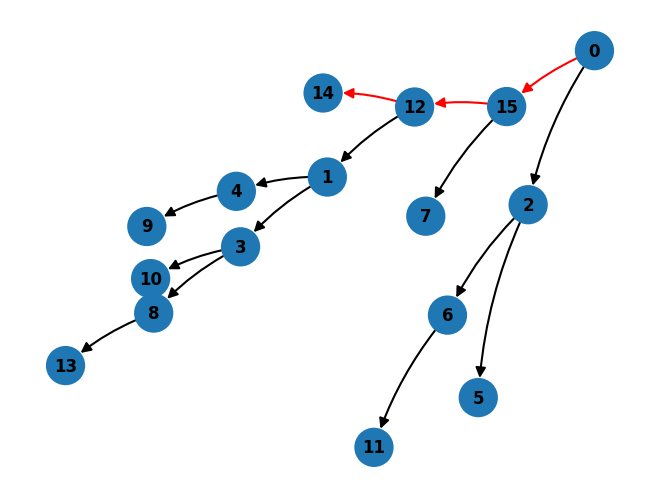

>2_position 28
filter_subpaths={(41, ','): ['12', '4', '0']}
['N0_1', 'N1_>13', 'N2_,', 'N3_14', 'N4_>1', 'N5_,', 'N6_10', 'N7_>14', 'N8_,', 'N9_7', 'N10_>10', 'N11_,', 'N12_7', 'N13_>3', 'N14_,', 'N15_6', 'N16_>7', 'N17_,', 'N18_8', 'N19_>6', 'N20_,', 'N21_9', 'N22_>8', 'N23_,', 'N24_11', 'N25_>9', 'N26_,', 'N27_11', 'N28_>2', 'N29_,', 'N30_5', 'N31_>11', 'N32_,', 'N33_12', 'N34_>5', 'N35_,', 'N36_4', 'N37_>12', 'N38_,', 'N39_0', 'N40_>4', 'N41_,', 'N42_15', 'N43_>0', 'N44_|', 'N45_13', 'N46_:', 'N47_15', 'N48_>0', 'N49_>4', 'N50_>12', 'N51_>5', 'N52_>11', 'N53_>9', 'N54_>8', 'N55_>6', 'N56_>7', 'N57_>10', 'N58_>14', 'N59_>1', 'N60_>13', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
1>13,14>1,10>14,7>10,7>3,6>7,8>6,9>8,11>9,11>2,5>11,12>5,4>12,0>4,15>0|13:15>0>4>12>5>11>9>8>6>7>10>14>1>13


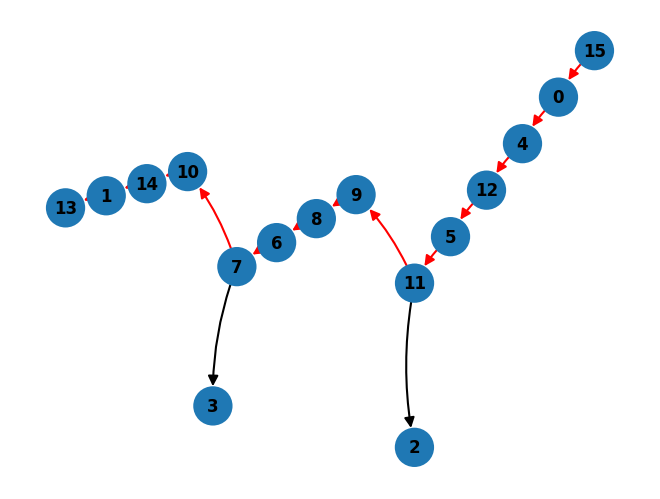

>2_position 43
filter_subpaths={}
['N0_5', 'N1_>10', 'N2_,', 'N3_8', 'N4_>5', 'N5_,', 'N6_14', 'N7_>15', 'N8_,', 'N9_14', 'N10_>8', 'N11_,', 'N12_13', 'N13_>14', 'N14_,', 'N15_1', 'N16_>13', 'N17_,', 'N18_1', 'N19_>0', 'N20_,', 'N21_6', 'N22_>1', 'N23_,', 'N24_4', 'N25_>6', 'N26_,', 'N27_3', 'N28_>12', 'N29_,', 'N30_3', 'N31_>4', 'N32_,', 'N33_7', 'N34_>3', 'N35_,', 'N36_9', 'N37_>7', 'N38_,', 'N39_2', 'N40_>9', 'N41_,', 'N42_11', 'N43_>2', 'N44_|', 'N45_10', 'N46_:', 'N47_11', 'N48_>2', 'N49_>9', 'N50_>7', 'N51_>3', 'N52_>4', 'N53_>6', 'N54_>1', 'N55_>13', 'N56_>14', 'N57_>8', 'N58_>5', 'N59_>10', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
5>10,8>5,14>15,14>8,13>14,1>13,1>0,6>1,4>6,3>12,3>4,7>3,9>7,2>9,11>2|10:11>2>9>7>3>4>6>1>13>14>8>5>10


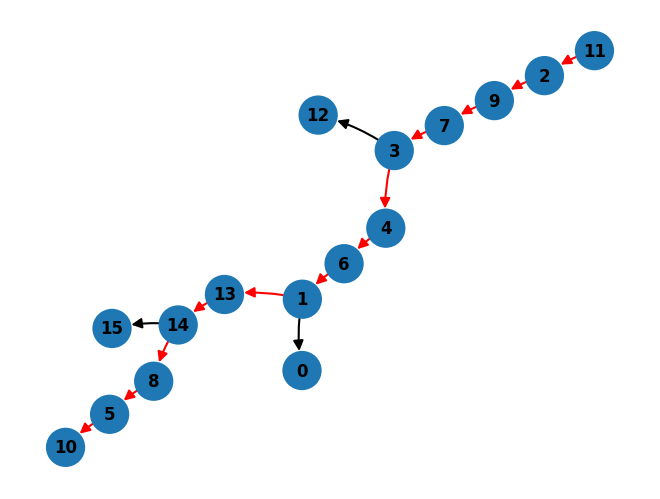

>2_position 43
filter_subpaths={}
['N0_7', 'N1_>15', 'N2_,', 'N3_6', 'N4_>7', 'N5_,', 'N6_13', 'N7_>9', 'N8_,', 'N9_13', 'N10_>6', 'N11_,', 'N12_12', 'N13_>13', 'N14_,', 'N15_14', 'N16_>12', 'N17_,', 'N18_5', 'N19_>14', 'N20_,', 'N21_10', 'N22_>5', 'N23_,', 'N24_10', 'N25_>1', 'N26_,', 'N27_11', 'N28_>10', 'N29_,', 'N30_8', 'N31_>11', 'N32_,', 'N33_3', 'N34_>8', 'N35_,', 'N36_0', 'N37_>3', 'N38_,', 'N39_2', 'N40_>0', 'N41_,', 'N42_4', 'N43_>2', 'N44_|', 'N45_15', 'N46_:', 'N47_4', 'N48_>2', 'N49_>0', 'N50_>3', 'N51_>8', 'N52_>11', 'N53_>10', 'N54_>5', 'N55_>14', 'N56_>12', 'N57_>13', 'N58_>6', 'N59_>7', 'N60_>15', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
7>15,6>7,13>9,13>6,12>13,14>12,5>14,10>5,10>1,11>10,8>11,3>8,0>3,2>0,4>2|15:4>2>0>3>8>11>10>5>14>12>13>6>7>15


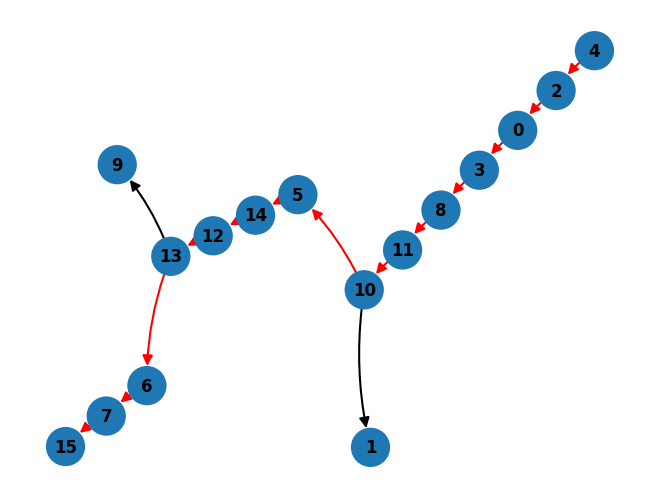

In [19]:
subpath_filtered(20,subpath_position=41,print_position_token=">2",node_filter="2",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

>11_position 1
filter_subpaths={(42, '6'): ['5', '3', '2']}
['N0_7', 'N1_>11', 'N2_,', 'N3_7', 'N4_>8', 'N5_,', 'N6_9', 'N7_>15', 'N8_,', 'N9_9', 'N10_>13', 'N11_,', 'N12_5', 'N13_>7', 'N14_,', 'N15_1', 'N16_>10', 'N17_,', 'N18_1', 'N19_>9', 'N20_,', 'N21_3', 'N22_>12', 'N23_,', 'N24_3', 'N25_>5', 'N26_,', 'N27_14', 'N28_>1', 'N29_,', 'N30_14', 'N31_>0', 'N32_,', 'N33_2', 'N34_>4', 'N35_,', 'N36_2', 'N37_>3', 'N38_,', 'N39_6', 'N40_>14', 'N41_,', 'N42_6', 'N43_>2', 'N44_|', 'N45_0', 'N46_:', 'N47_6', 'N48_>14', 'N49_>0', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
7>11,7>8,9>15,9>13,5>7,1>10,1>9,3>12,3>5,14>1,14>0,2>4,2>3,6>14,6>2|0:6>14>0


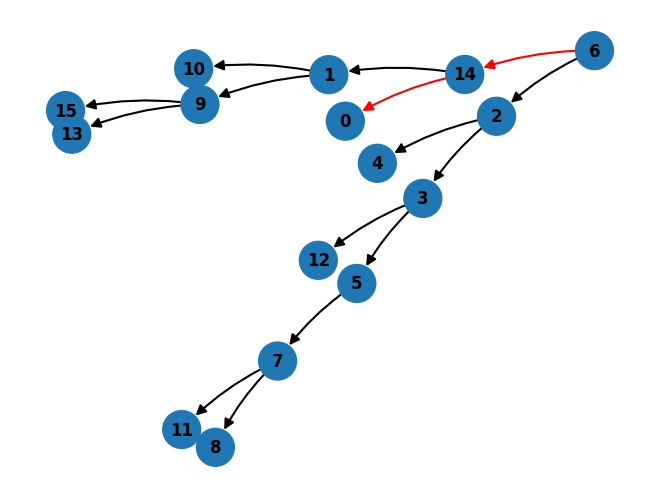

>11_position 4
filter_subpaths={(42, '6'): ['0', '8', '6']}
['N0_10', 'N1_>13', 'N2_,', 'N3_10', 'N4_>11', 'N5_,', 'N6_0', 'N7_>5', 'N8_,', 'N9_0', 'N10_>3', 'N11_,', 'N12_9', 'N13_>14', 'N14_,', 'N15_7', 'N16_>12', 'N17_,', 'N18_7', 'N19_>10', 'N20_,', 'N21_8', 'N22_>4', 'N23_,', 'N24_8', 'N25_>0', 'N26_,', 'N27_1', 'N28_>9', 'N29_,', 'N30_1', 'N31_>7', 'N32_,', 'N33_15', 'N34_>8', 'N35_,', 'N36_15', 'N37_>1', 'N38_,', 'N39_6', 'N40_>15', 'N41_,', 'N42_6', 'N43_>2', 'N44_|', 'N45_4', 'N46_:', 'N47_6', 'N48_>15', 'N49_>8', 'N50_>4', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
10>13,10>11,0>5,0>3,9>14,7>12,7>10,8>4,8>0,1>9,1>7,15>8,15>1,6>15,6>2|4:6>15>8>4


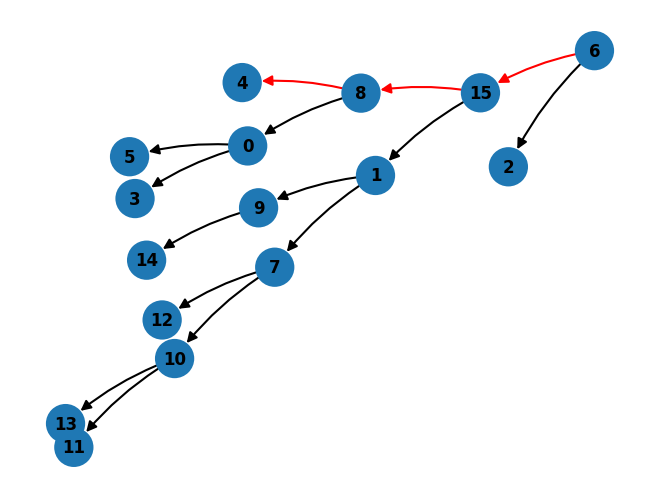

>11_position 13
filter_subpaths={(42, '0'): ['5', '3', '1']}
['N0_12', 'N1_>14', 'N2_,', 'N3_6', 'N4_>15', 'N5_,', 'N6_6', 'N7_>12', 'N8_,', 'N9_7', 'N10_>13', 'N11_,', 'N12_5', 'N13_>11', 'N14_,', 'N15_5', 'N16_>6', 'N17_,', 'N18_4', 'N19_>8', 'N20_,', 'N21_4', 'N22_>7', 'N23_,', 'N24_3', 'N25_>5', 'N26_,', 'N27_2', 'N28_>10', 'N29_,', 'N30_2', 'N31_>4', 'N32_,', 'N33_1', 'N34_>3', 'N35_,', 'N36_1', 'N37_>2', 'N38_,', 'N39_0', 'N40_>9', 'N41_,', 'N42_0', 'N43_>1', 'N44_|', 'N45_9', 'N46_:', 'N47_0', 'N48_>9', 'N49_,', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>14,6>15,6>12,7>13,5>11,5>6,4>8,4>7,3>5,2>10,2>4,1>3,1>2,0>9,0>1|9:0>9


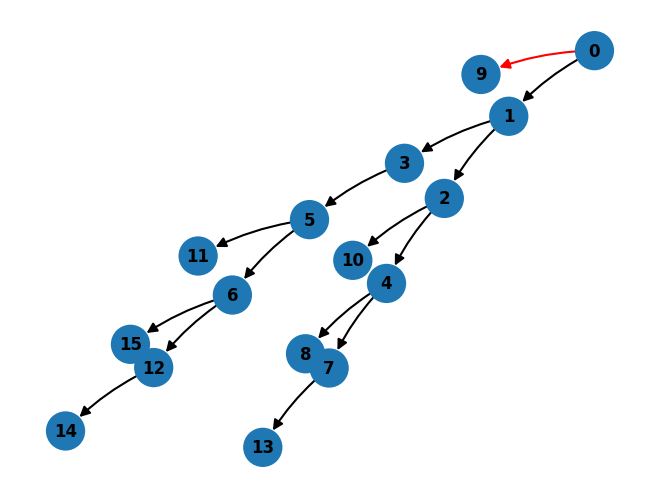

>11_position -1
filter_subpaths={(42, '11'): ['5', '13', '7', '6']}
['N0_14', 'N1_>12', 'N2_,', 'N3_14', 'N4_>10', 'N5_,', 'N6_4', 'N7_>14', 'N8_,', 'N9_9', 'N10_>4', 'N11_,', 'N12_15', 'N13_>9', 'N14_,', 'N15_1', 'N16_>15', 'N17_,', 'N18_3', 'N19_>1', 'N20_,', 'N21_2', 'N22_>3', 'N23_,', 'N24_5', 'N25_>2', 'N26_,', 'N27_13', 'N28_>5', 'N29_,', 'N30_7', 'N31_>13', 'N32_,', 'N33_6', 'N34_>7', 'N35_,', 'N36_0', 'N37_>6', 'N38_,', 'N39_8', 'N40_>0', 'N41_,', 'N42_11', 'N43_>8', 'N44_|', 'N45_10', 'N46_:', 'N47_11', 'N48_>8', 'N49_>0', 'N50_>6', 'N51_>7', 'N52_>13', 'N53_>5', 'N54_>2', 'N55_>3', 'N56_>1', 'N57_>15', 'N58_>9', 'N59_>4', 'N60_>14', 'N61_>10', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
14>12,14>10,4>14,9>4,15>9,1>15,3>1,2>3,5>2,13>5,7>13,6>7,0>6,8>0,11>8|10:11>8>0>6>7>13>5>2>3>1>15>9>4>14>10


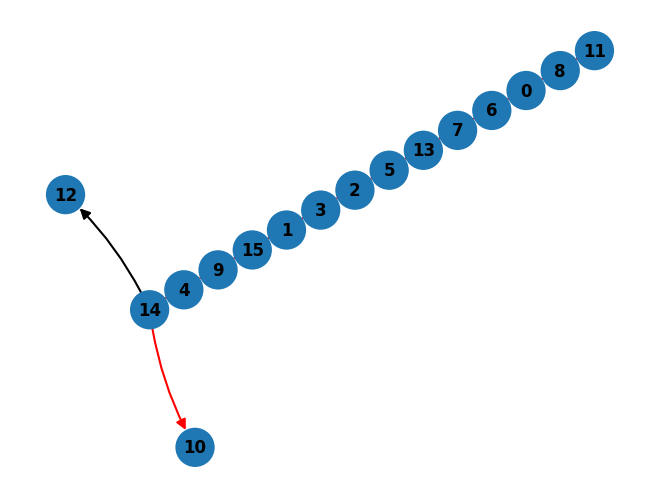

>11_position 7
filter_subpaths={(42, '14'): ['12', '10', '9', '4']}
['N0_12', 'N1_>15', 'N2_,', 'N3_10', 'N4_>12', 'N5_,', 'N6_9', 'N7_>11', 'N8_,', 'N9_9', 'N10_>10', 'N11_,', 'N12_4', 'N13_>9', 'N14_,', 'N15_4', 'N16_>5', 'N17_,', 'N18_6', 'N19_>13', 'N20_,', 'N21_3', 'N22_>8', 'N23_,', 'N24_3', 'N25_>4', 'N26_,', 'N27_1', 'N28_>6', 'N29_,', 'N30_1', 'N31_>3', 'N32_,', 'N33_0', 'N34_>7', 'N35_,', 'N36_0', 'N37_>1', 'N38_,', 'N39_14', 'N40_>2', 'N41_,', 'N42_14', 'N43_>0', 'N44_|', 'N45_2', 'N46_:', 'N47_14', 'N48_>2', 'N49_,', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>15,10>12,9>11,9>10,4>9,4>5,6>13,3>8,3>4,1>6,1>3,0>7,0>1,14>2,14>0|2:14>2


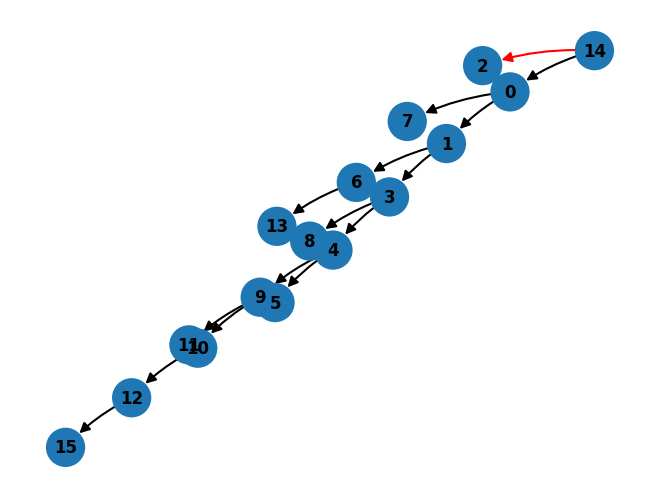

>11_position 34
filter_subpaths={(42, '7'): ['5', '1', '14', '3']}
['N0_10', 'N1_>15', 'N2_,', 'N3_5', 'N4_>10', 'N5_,', 'N6_9', 'N7_>12', 'N8_,', 'N9_1', 'N10_>5', 'N11_,', 'N12_14', 'N13_>9', 'N14_,', 'N15_14', 'N16_>1', 'N17_,', 'N18_3', 'N19_>14', 'N20_,', 'N21_3', 'N22_>6', 'N23_,', 'N24_0', 'N25_>3', 'N26_,', 'N27_4', 'N28_>2', 'N29_,', 'N30_4', 'N31_>0', 'N32_,', 'N33_8', 'N34_>11', 'N35_,', 'N36_8', 'N37_>4', 'N38_,', 'N39_7', 'N40_>13', 'N41_,', 'N42_7', 'N43_>8', 'N44_|', 'N45_12', 'N46_:', 'N47_7', 'N48_>8', 'N49_>4', 'N50_>0', 'N51_>3', 'N52_>14', 'N53_>9', 'N54_>12', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
10>15,5>10,9>12,1>5,14>9,14>1,3>14,3>6,0>3,4>2,4>0,8>11,8>4,7>13,7>8|12:7>8>4>0>3>14>9>12


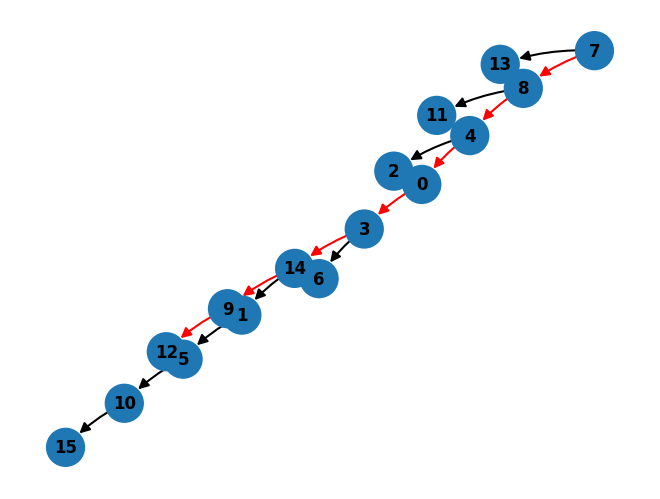

>11_position 1
filter_subpaths={(42, '5'): ['8', '4']}
['N0_10', 'N1_>11', 'N2_,', 'N3_8', 'N4_>15', 'N5_,', 'N6_8', 'N7_>12', 'N8_,', 'N9_3', 'N10_>6', 'N11_,', 'N12_4', 'N13_>10', 'N14_,', 'N15_4', 'N16_>8', 'N17_,', 'N18_7', 'N19_>13', 'N20_,', 'N21_7', 'N22_>3', 'N23_,', 'N24_2', 'N25_>4', 'N26_,', 'N27_1', 'N28_>7', 'N29_,', 'N30_1', 'N31_>2', 'N32_,', 'N33_0', 'N34_>14', 'N35_,', 'N36_0', 'N37_>9', 'N38_,', 'N39_5', 'N40_>1', 'N41_,', 'N42_5', 'N43_>0', 'N44_|', 'N45_13', 'N46_:', 'N47_5', 'N48_>1', 'N49_>7', 'N50_>13', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
10>11,8>15,8>12,3>6,4>10,4>8,7>13,7>3,2>4,1>7,1>2,0>14,0>9,5>1,5>0|13:5>1>7>13


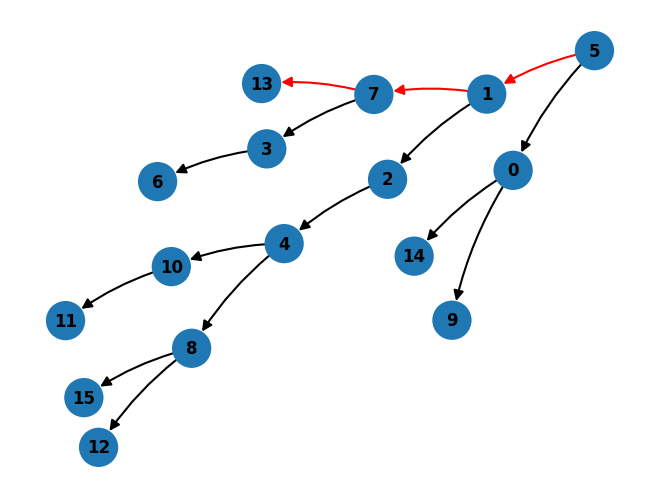

>11_position 43
filter_subpaths={(42, '2'): ['8', '1', '3']}
['N0_15', 'N1_>9', 'N2_,', 'N3_7', 'N4_>15', 'N5_,', 'N6_14', 'N7_>7', 'N8_,', 'N9_0', 'N10_>14', 'N11_,', 'N12_13', 'N13_>0', 'N14_,', 'N15_4', 'N16_>13', 'N17_,', 'N18_12', 'N19_>4', 'N20_,', 'N21_5', 'N22_>12', 'N23_,', 'N24_8', 'N25_>10', 'N26_,', 'N27_8', 'N28_>5', 'N29_,', 'N30_1', 'N31_>8', 'N32_,', 'N33_3', 'N34_>1', 'N35_,', 'N36_6', 'N37_>3', 'N38_,', 'N39_11', 'N40_>6', 'N41_,', 'N42_2', 'N43_>11', 'N44_|', 'N45_9', 'N46_:', 'N47_2', 'N48_>11', 'N49_>6', 'N50_>3', 'N51_>1', 'N52_>8', 'N53_>5', 'N54_>12', 'N55_>4', 'N56_>13', 'N57_>0', 'N58_>14', 'N59_>7', 'N60_>15', 'N61_>9', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
15>9,7>15,14>7,0>14,13>0,4>13,12>4,5>12,8>10,8>5,1>8,3>1,6>3,11>6,2>11|9:2>11>6>3>1>8>5>12>4>13>0>14>7>15>9


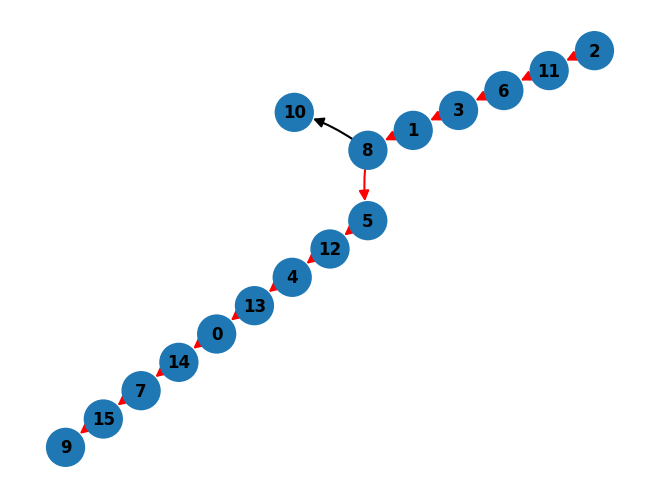

>11_position 31
filter_subpaths={(42, '3'): ['12', '7', '4', '3']}
['N0_0', 'N1_>5', 'N2_,', 'N3_14', 'N4_>15', 'N5_,', 'N6_6', 'N7_>9', 'N8_,', 'N9_6', 'N10_>8', 'N11_,', 'N12_2', 'N13_>13', 'N14_,', 'N15_2', 'N16_>0', 'N17_,', 'N18_12', 'N19_>14', 'N20_,', 'N21_10', 'N22_>6', 'N23_,', 'N24_10', 'N25_>2', 'N26_,', 'N27_7', 'N28_>12', 'N29_,', 'N30_7', 'N31_>11', 'N32_,', 'N33_4', 'N34_>10', 'N35_,', 'N36_4', 'N37_>7', 'N38_,', 'N39_3', 'N40_>4', 'N41_,', 'N42_3', 'N43_>1', 'N44_|', 'N45_13', 'N46_:', 'N47_3', 'N48_>4', 'N49_>10', 'N50_>2', 'N51_>13', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
0>5,14>15,6>9,6>8,2>13,2>0,12>14,10>6,10>2,7>12,7>11,4>10,4>7,3>4,3>1|13:3>4>10>2>13


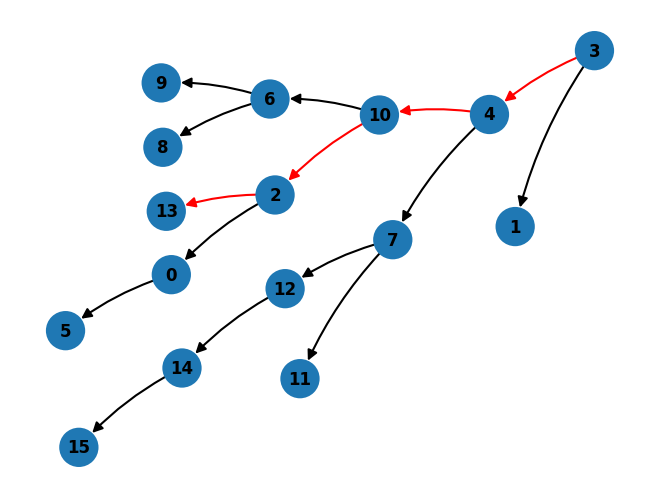

>11_position 22
filter_subpaths={(42, '9'): ['5', '13', '8', '7']}
['N0_3', 'N1_>12', 'N2_,', 'N3_14', 'N4_>3', 'N5_,', 'N6_6', 'N7_>14', 'N8_,', 'N9_0', 'N10_>6', 'N11_,', 'N12_0', 'N13_>4', 'N14_,', 'N15_15', 'N16_>0', 'N17_,', 'N18_2', 'N19_>15', 'N20_,', 'N21_5', 'N22_>11', 'N23_,', 'N24_5', 'N25_>2', 'N26_,', 'N27_13', 'N28_>5', 'N29_,', 'N30_8', 'N31_>13', 'N32_,', 'N33_8', 'N34_>1', 'N35_,', 'N36_7', 'N37_>8', 'N38_,', 'N39_10', 'N40_>7', 'N41_,', 'N42_9', 'N43_>10', 'N44_|', 'N45_12', 'N46_:', 'N47_9', 'N48_>10', 'N49_>7', 'N50_>8', 'N51_>13', 'N52_>5', 'N53_>2', 'N54_>15', 'N55_>0', 'N56_>6', 'N57_>14', 'N58_>3', 'N59_>12', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
3>12,14>3,6>14,0>6,0>4,15>0,2>15,5>11,5>2,13>5,8>13,8>1,7>8,10>7,9>10|12:9>10>7>8>13>5>2>15>0>6>14>3>12


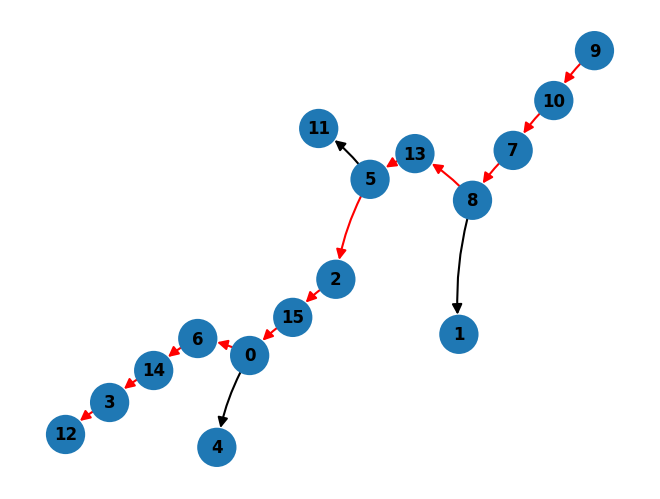

>11_position 1
filter_subpaths={(42, '14'): ['5', '13', '14']}
['N0_6', 'N1_>11', 'N2_,', 'N3_10', 'N4_>9', 'N5_,', 'N6_10', 'N7_>8', 'N8_,', 'N9_0', 'N10_>6', 'N11_,', 'N12_15', 'N13_>10', 'N14_,', 'N15_15', 'N16_>0', 'N17_,', 'N18_5', 'N19_>7', 'N20_,', 'N21_4', 'N22_>15', 'N23_,', 'N24_2', 'N25_>12', 'N26_,', 'N27_13', 'N28_>5', 'N29_,', 'N30_13', 'N31_>4', 'N32_,', 'N33_1', 'N34_>3', 'N35_,', 'N36_1', 'N37_>2', 'N38_,', 'N39_14', 'N40_>13', 'N41_,', 'N42_14', 'N43_>1', 'N44_|', 'N45_8', 'N46_:', 'N47_14', 'N48_>13', 'N49_>4', 'N50_>15', 'N51_>10', 'N52_>8', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
6>11,10>9,10>8,0>6,15>10,15>0,5>7,4>15,2>12,13>5,13>4,1>3,1>2,14>13,14>1|8:14>13>4>15>10>8


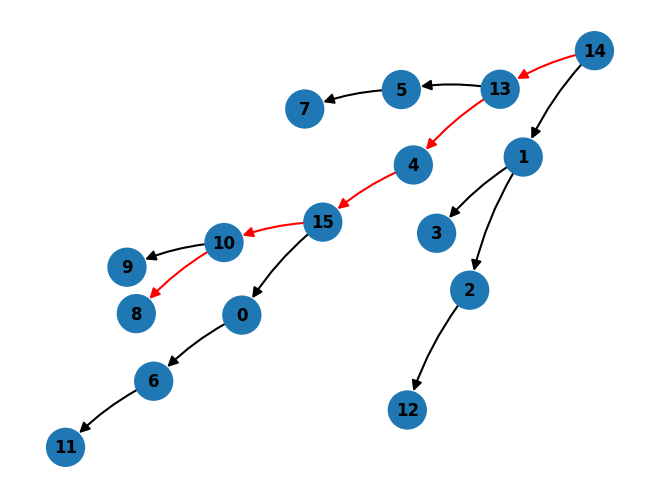

In [20]:
subpath_filtered(20,subpath_position=42,print_position_token=">11",node_filter="11",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

>1_position 19
filter_subpaths={(44, '|'): ['5', '2', '10', '11']}
['N0_12', 'N1_>13', 'N2_,', 'N3_9', 'N4_>7', 'N5_,', 'N6_9', 'N7_>0', 'N8_,', 'N9_8', 'N10_>12', 'N11_,', 'N12_4', 'N13_>15', 'N14_,', 'N15_3', 'N16_>9', 'N17_,', 'N18_3', 'N19_>1', 'N20_,', 'N21_5', 'N22_>8', 'N23_,', 'N24_14', 'N25_>4', 'N26_,', 'N27_14', 'N28_>3', 'N29_,', 'N30_2', 'N31_>5', 'N32_,', 'N33_10', 'N34_>14', 'N35_,', 'N36_10', 'N37_>2', 'N38_,', 'N39_11', 'N40_>10', 'N41_,', 'N42_11', 'N43_>6', 'N44_|', 'N45_7', 'N46_:', 'N47_11', 'N48_>10', 'N49_>14', 'N50_>3', 'N51_>9', 'N52_>7', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>13,9>7,9>0,8>12,4>15,3>9,3>1,5>8,14>4,14>3,2>5,10>14,10>2,11>10,11>6|7:11>10>14>3>9>7


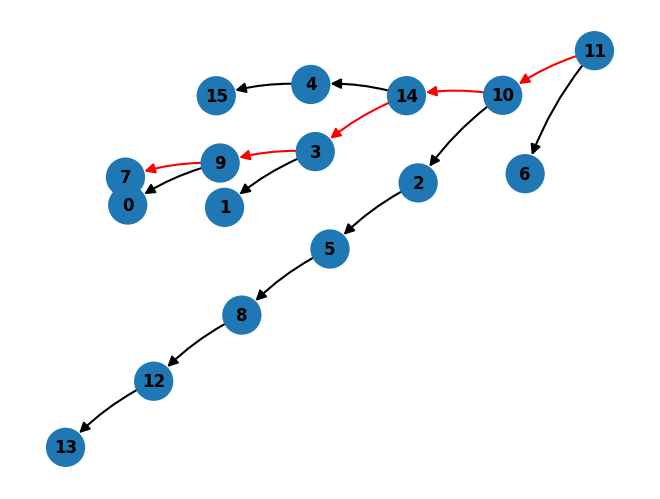

>1_position 13
filter_subpaths={(44, '|'): ['5', '15', '7', '14']}
['N0_12', 'N1_>13', 'N2_,', 'N3_8', 'N4_>9', 'N5_,', 'N6_0', 'N7_>12', 'N8_,', 'N9_0', 'N10_>8', 'N11_,', 'N12_5', 'N13_>1', 'N14_,', 'N15_5', 'N16_>0', 'N17_,', 'N18_15', 'N19_>5', 'N20_,', 'N21_7', 'N22_>15', 'N23_,', 'N24_14', 'N25_>7', 'N26_,', 'N27_10', 'N28_>11', 'N29_,', 'N30_3', 'N31_>14', 'N32_,', 'N33_3', 'N34_>10', 'N35_,', 'N36_4', 'N37_>3', 'N38_,', 'N39_4', 'N40_>2', 'N41_,', 'N42_6', 'N43_>4', 'N44_|', 'N45_13', 'N46_:', 'N47_6', 'N48_>4', 'N49_>3', 'N50_>14', 'N51_>7', 'N52_>15', 'N53_>5', 'N54_>0', 'N55_>12', 'N56_>13', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>13,8>9,0>12,0>8,5>1,5>0,15>5,7>15,14>7,10>11,3>14,3>10,4>3,4>2,6>4|13:6>4>3>14>7>15>5>0>12>13


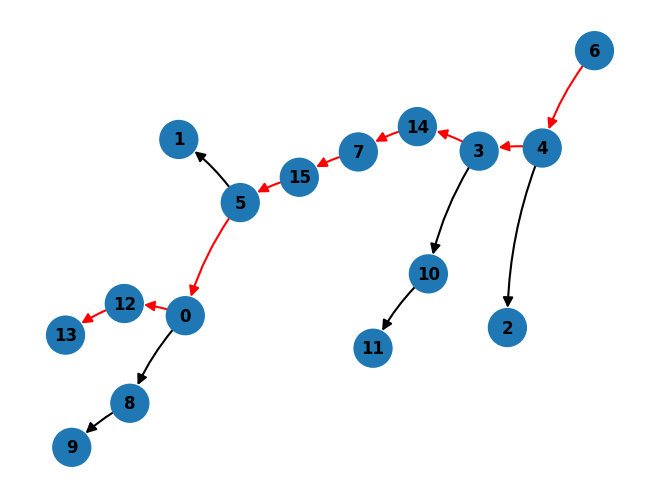

>1_position 13
filter_subpaths={(44, '|'): ['8', '3', '6', ',']}
['N0_2', 'N1_>13', 'N2_,', 'N3_2', 'N4_>9', 'N5_,', 'N6_5', 'N7_>2', 'N8_,', 'N9_8', 'N10_>5', 'N11_,', 'N12_8', 'N13_>1', 'N14_,', 'N15_3', 'N16_>8', 'N17_,', 'N18_3', 'N19_>0', 'N20_,', 'N21_11', 'N22_>3', 'N23_,', 'N24_7', 'N25_>15', 'N26_,', 'N27_7', 'N28_>11', 'N29_,', 'N30_12', 'N31_>7', 'N32_,', 'N33_4', 'N34_>12', 'N35_,', 'N36_10', 'N37_>4', 'N38_,', 'N39_14', 'N40_>10', 'N41_,', 'N42_6', 'N43_>14', 'N44_|', 'N45_9', 'N46_:', 'N47_6', 'N48_>14', 'N49_>10', 'N50_>4', 'N51_>12', 'N52_>7', 'N53_>11', 'N54_>3', 'N55_>8', 'N56_>5', 'N57_>2', 'N58_>9', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
2>13,2>9,5>2,8>5,8>1,3>8,3>0,11>3,7>15,7>11,12>7,4>12,10>4,14>10,6>14|9:6>14>10>4>12>7>11>3>8>5>2>9


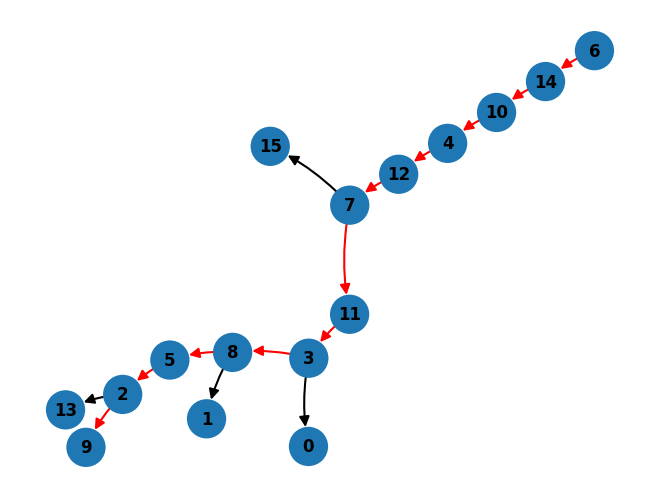

>1_position 1
filter_subpaths={(44, '|'): ['2', '8', '3']}
['N0_12', 'N1_>1', 'N2_,', 'N3_6', 'N4_>15', 'N5_,', 'N6_11', 'N7_>12', 'N8_,', 'N9_11', 'N10_>6', 'N11_,', 'N12_0', 'N13_>11', 'N14_,', 'N15_9', 'N16_>0', 'N17_,', 'N18_4', 'N19_>10', 'N20_,', 'N21_14', 'N22_>9', 'N23_,', 'N24_14', 'N25_>4', 'N26_,', 'N27_7', 'N28_>14', 'N29_,', 'N30_7', 'N31_>13', 'N32_,', 'N33_5', 'N34_>7', 'N35_,', 'N36_2', 'N37_>5', 'N38_,', 'N39_8', 'N40_>2', 'N41_,', 'N42_3', 'N43_>8', 'N44_|', 'N45_1', 'N46_:', 'N47_3', 'N48_>8', 'N49_>2', 'N50_>5', 'N51_>7', 'N52_>14', 'N53_>9', 'N54_>0', 'N55_>11', 'N56_>12', 'N57_>1', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>1,6>15,11>12,11>6,0>11,9>0,4>10,14>9,14>4,7>14,7>13,5>7,2>5,8>2,3>8|1:3>8>2>5>7>14>9>0>11>12>1


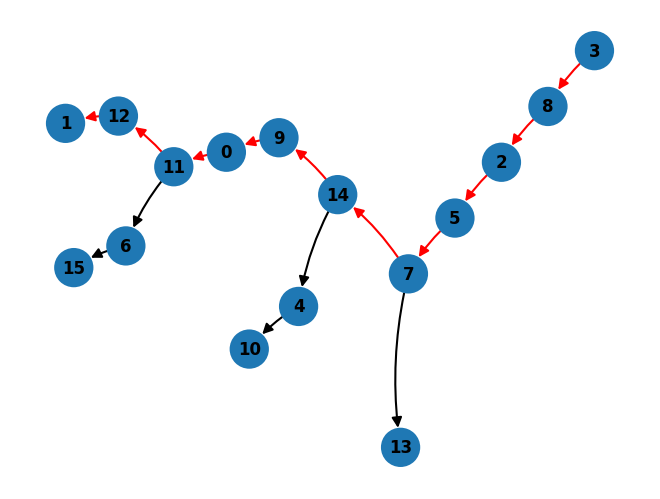

>1_position 16
filter_subpaths={(44, '|'): ['0', '8', '8', '7']}
['N0_12', 'N1_>11', 'N2_,', 'N3_12', 'N4_>3', 'N5_,', 'N6_4', 'N7_>15', 'N8_,', 'N9_4', 'N10_>10', 'N11_,', 'N12_6', 'N13_>12', 'N14_,', 'N15_6', 'N16_>1', 'N17_,', 'N18_2', 'N19_>5', 'N20_,', 'N21_2', 'N22_>4', 'N23_,', 'N24_13', 'N25_>14', 'N26_,', 'N27_0', 'N28_>6', 'N29_,', 'N30_0', 'N31_>2', 'N32_,', 'N33_8', 'N34_>13', 'N35_,', 'N36_8', 'N37_>0', 'N38_,', 'N39_7', 'N40_>9', 'N41_,', 'N42_7', 'N43_>8', 'N44_|', 'N45_3', 'N46_:', 'N47_7', 'N48_>8', 'N49_>0', 'N50_>6', 'N51_>12', 'N52_>3', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
12>11,12>3,4>15,4>10,6>12,6>1,2>5,2>4,13>14,0>6,0>2,8>13,8>0,7>9,7>8|3:7>8>0>6>12>3


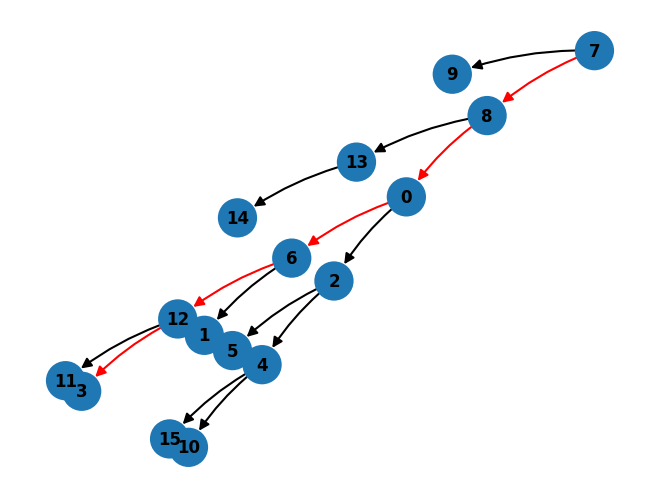

>1_position 4
filter_subpaths={(44, '|'): ['11', '13', '10']}
['N0_11', 'N1_>6', 'N2_,', 'N3_11', 'N4_>1', 'N5_,', 'N6_9', 'N7_>14', 'N8_,', 'N9_13', 'N10_>11', 'N11_,', 'N12_13', 'N13_>3', 'N14_,', 'N15_2', 'N16_>9', 'N17_,', 'N18_7', 'N19_>13', 'N20_,', 'N21_7', 'N22_>2', 'N23_,', 'N24_15', 'N25_>7', 'N26_,', 'N27_0', 'N28_>15', 'N29_,', 'N30_10', 'N31_>0', 'N32_,', 'N33_4', 'N34_>10', 'N35_,', 'N36_4', 'N37_>5', 'N38_,', 'N39_8', 'N40_>12', 'N41_,', 'N42_8', 'N43_>4', 'N44_|', 'N45_6', 'N46_:', 'N47_8', 'N48_>4', 'N49_>10', 'N50_>0', 'N51_>15', 'N52_>7', 'N53_>13', 'N54_>11', 'N55_>6', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
11>6,11>1,9>14,13>11,13>3,2>9,7>13,7>2,15>7,0>15,10>0,4>10,4>5,8>12,8>4|6:8>4>10>0>15>7>13>11>6


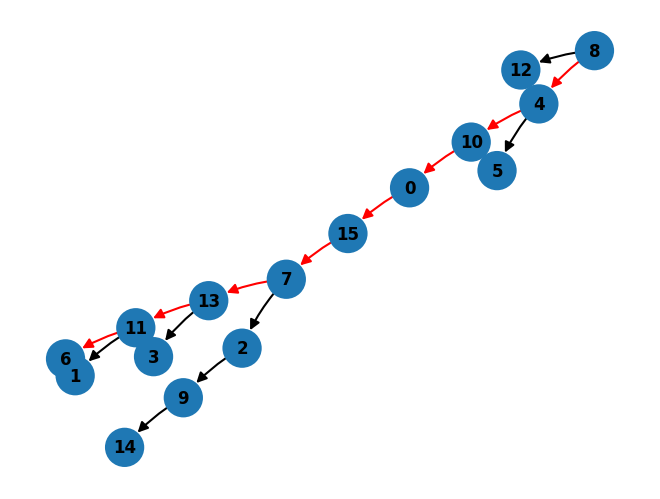

In [21]:
subpath_filtered(20,subpath_position=44,print_position_token=">1",node_filter="1",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

In [22]:
import random
n_examples = 3000
subpaths_all_backward =[]
token_positions_all_backward  =[]
all_graphs_backward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    all_graphs_backward.append(graph)
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)
    
    token_positions={}
    for i, component in enumerate(graph_split):
            token_positions[dataset.idx2tokens[component]]=i
            if i>44:
                  break
    token_positions_all_backward.append(token_positions)           
    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_backward.append(subpaths)

In [23]:
import random
n_examples = 3000
subpaths_all_random =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="random")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_random.append(subpaths)


In [24]:
from collections import Counter
results={}
for subpath in subpaths_all_backward:
    for key, value in subpath.items():
        if key[0] in results:
                results[key[0]].append(value[0])
        elif key[0]<47:
            results[key[0]]=[]
            results[key[0]].append(value[0])
          
for key, value in results.items():
    occurrences = Counter(value)
    total_count = len(value)
    percentages= []
    occurrences_sorted = sorted(occurrences.items(),key=lambda x: x[1], reverse=True)
    for key_occ, value_occ in occurrences_sorted:
        percentage = (value_occ / total_count) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")
    print(f'{key}: total{total_count} {percentages}')


38: total2157 ['10: 100.00%']
39: total2007 ['3: 68.61%', '0: 4.58%', '8: 4.48%', '9: 4.33%', '5: 4.09%', '7: 3.54%', '13: 1.44%', '14: 1.40%', '10: 1.40%', '1: 1.30%', '6: 1.20%', '11: 1.00%', '12: 1.00%', '15: 0.95%', '2: 0.65%', '4: 0.05%']
41: total2012 ['2: 76.69%', '0: 17.94%', '15: 1.84%', '14: 0.65%', '6: 0.65%', '8: 0.35%', '12: 0.35%', '3: 0.30%', '7: 0.25%', '1: 0.25%', '11: 0.25%', '13: 0.15%', '9: 0.15%', '5: 0.10%', '10: 0.10%']
42: total2193 ['11: 57.36%', '5: 17.97%', '12: 14.27%', '0: 1.60%', '8: 1.37%', '14: 1.32%', '6: 0.91%', '15: 0.82%', '3: 0.73%', '10: 0.68%', '1: 0.68%', '13: 0.68%', '7: 0.55%', '9: 0.41%', '2: 0.41%', '4: 0.23%']
45: total2183 ['4: 85.85%', '12: 3.39%', '0: 2.70%', '7: 2.29%', '8: 1.33%', '6: 0.87%', '14: 0.78%', '11: 0.46%', '9: 0.37%', '10: 0.37%', '2: 0.32%', '15: 0.27%', '13: 0.27%', '1: 0.27%', '5: 0.23%', '3: 0.23%']
36: total1822 ['6: 68.72%', '12: 9.11%', '0: 5.27%', '5: 3.57%', '15: 3.18%', '10: 1.87%', '9: 1.43%', '14: 1.21%', '7: 1.0

In [39]:
position_list=[36,38,39,41,42,44,45]
prefered_token_list=[">6",">10",">3",">2",">11",">1",">4"]
results_condition_true={}
results_condition_false={}

subpaths_all_backward_by_position=[]
for supath in subpaths_all_backward:
    new_subpath={}
    for key,value in supath.items():#undoing yanniks weird key think probably should just modify the subpaths function.
        new_subpath[key[0]]=value 
    subpaths_all_backward_by_position.append(new_subpath)

for i,subpath in enumerate(subpaths_all_backward_by_position):
    for j,position in enumerate(position_list):
        if position in subpath:
            value=subpath[position][0]
        else:
            value=None

        if prefered_token_list[j] in token_positions_all_backward[i] and prefered_token_list[j][1:] in token_positions_all_backward[i] and token_positions_all_backward[i][prefered_token_list[j]] <= position:#prefered_token_list[j][1:] token without >
            if position in results_condition_true:
                results_condition_true[position].append(value)
            else:
                results_condition_true[position]=[]
                results_condition_true[position].append(value)
        else:
            if position in results_condition_false:
                results_condition_false[position].append(value)
            else:
                results_condition_false[position]=[]
                results_condition_false[position].append(value)    


for i,(key, value) in enumerate(results_condition_true.items()):
    value_false=results_condition_false[key]
    occurrences = Counter(value)
    occurrences_false = Counter(value_false)
    total_count = len(value)
    total_count_false = len(value_false)
    percentages = []
    percentages_false= []
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentage_false = (occurrences_false[key_occ] / total_count_false) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")
        percentages_false.append(f"{key_occ}: {percentage_false:.2f}%")
    print(f'when {prefered_token_list[i]} is not a leaf and before position {key}')
    print(f'{key}: total{total_count} {percentages}')
    print(f'when {prefered_token_list[i]} is a leaf or after {key}')
    print(f'{key}: total{total_count} {percentages_false}')




when >6 is not a leaf and before position 39
39: total1954 ['3: 70.47%', '6: 0.10%', 'None: 21.75%', '0: 0.97%', '5: 1.07%', '7: 0.92%', '14: 0.26%', '13: 0.41%', '11: 0.46%', '1: 0.46%', '8: 1.07%', '9: 0.82%', '15: 0.36%', '2: 0.31%', '12: 0.26%', '4: 0.05%', '10: 0.26%']
when >6 is a leaf or after 39
39: total1954 ['3: 0.00%', '6: 2.10%', 'None: 54.30%', '0: 6.98%', '5: 5.83%', '7: 5.07%', '14: 2.20%', '13: 2.01%', '11: 1.05%', '1: 1.63%', '8: 6.60%', '9: 6.79%', '15: 1.15%', '2: 0.67%', '12: 1.43%', '4: 0.00%', '10: 2.20%']
when >10 is not a leaf and before position 42
42: total1685 ['11: 74.66%', 'None: 16.50%', '12: 3.50%', '5: 3.74%', '15: 0.18%', '6: 0.12%', '8: 0.30%', '0: 0.30%', '2: 0.12%', '10: 0.06%', '3: 0.18%', '7: 0.06%', '13: 0.12%', '9: 0.06%', '1: 0.06%', '4: 0.06%']
when >10 is a leaf or after 42
42: total1685 ['11: 0.00%', 'None: 40.23%', '12: 19.32%', '5: 25.17%', '15: 1.14%', '6: 1.37%', '8: 1.90%', '0: 2.28%', '2: 0.53%', '10: 1.06%', '3: 0.99%', '7: 0.84%', '13

In [40]:
position_list=[36,38,39,41,42,44,45]
prefered_token_list=[">6",">10",">3",">2",">11",">1",">4"]
heatmap=[]
heatmap_false=[]
heatmap_total=[]
for i,(key, value) in enumerate(results_condition_true.items()):
    value_false=results_condition_false[key]
    occurrences = Counter(value)
    occurrences_false = Counter(value_false)
    total_count = len(value)
    total_count_false = len(value_false)
    percentages = []
    percentages_false= []
    heatmap.append(np.zeros(17))
    heatmap_false.append(np.zeros(17))
    heatmap_total.append(np.zeros(17))
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentage_false = (occurrences_false[key_occ] / total_count_false) * 100
        if (key_occ) is None:
            heatmap[i][16]=(percentage)
            heatmap_false[i][16]=(percentage_false)
            heatmap_total[i][16]=((value_occ+occurrences_false[key_occ])/(total_count_false+total_count))* 100
        else:
            heatmap[i][int(key_occ)]=(percentage)
            heatmap_false[i][int(key_occ)]=(percentage_false)
            heatmap_total[i][int(key_occ)]=((value_occ+occurrences_false[key_occ])/(total_count_false+total_count))* 100
            
            

In [41]:
range_list=list(range(16))
range_list.append("None")
x_axis= [str(i) for i in range_list]

In [28]:
x_axis

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 'None']

In [44]:
fig = px.imshow((np.array(heatmap_total)),x=x_axis,y=position_list,width=1000,height=500)
fig.update_yaxes(type='category')
fig.show()

In [30]:
fig = px.imshow((np.array(heatmap)),x=x_axis,y=position_list,width=1000,height=500)
fig.update_yaxes(type='category')
fig.show()

In [31]:
fig = px.imshow((np.array(heatmap_false)),x=x_axis,y=position_list,width=1000,height=500)
fig.update_yaxes(type='category')
fig.show()

## Check backup behaviour

In [33]:
position_list=[36]
prefered_token_list=[">6"]
backup_token_list=[[">0",">5"]]
results_condition_true_backup={}
results_condition_false_backup={}

subpaths_all_backward_by_position=[]
for supath in subpaths_all_backward:
    new_subpath={}
    for key,value in supath.items():#undoing yanniks weird key think probably should just modify the subpaths function.
        new_subpath[key[0]]=value 
    subpaths_all_backward_by_position.append(new_subpath)

for i,subpath in enumerate(subpaths_all_backward_by_position):
    for j,position in enumerate(position_list):
        if prefered_token_list[j] in token_positions_all_backward[i] and prefered_token_list[j][1:] in token_positions_all_backward[i]:#prefered_token_list[j][1:] token without >
            prefered_token_pos=token_positions_all_backward[i][prefered_token_list[j]]
        else:
            prefered_token_pos=None

        token_positions=[]
        for token in backup_token_list[j]:
            if token in token_positions_all_backward[i] and token[1:] in token_positions_all_backward[i] and token_positions_all_backward[i][token] <= position:
                token_positions.append(token_positions_all_backward[i][token])
            else:
                token_positions.append(None)
            
        if position in subpath:
                value=subpath[position][0]
        else:
                value=None

        if prefered_token_pos is not None and prefered_token_pos <= position and None not in token_positions:
            if position in results_condition_true:
                results_condition_true_backup[position].append(value)
            else:
                results_condition_true_backup[position]=[]
                results_condition_true_backup[position].append(value)
        else:
            if position in results_condition_false:
                results_condition_false_backup[position].append(value)
            else:
                results_condition_false_backup[position]=[]
                results_condition_false_backup[position].append(value)    


for i,(key, value) in enumerate(results_condition_true.items()):
    value_false=results_condition_false_backup[key]
    occurrences = Counter(value)
    occurrences_false = Counter(value_false)
    total_count = len(value)
    total_count_false = len(value_false)
    percentages = []
    percentages_false= []
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentage_false = (occurrences_false[key_occ] / total_count_false) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")
        percentages_false.append(f"{key_occ}: {percentage_false:.2f}%")
    print(f'when {prefered_token_list[i]} is not a leaf and before position {key}')
    print(f'{key}: total{total_count} {percentages}')
    print(f'when {prefered_token_list[i]} is a leaf or after {key}')
    print(f'{key}: total{total_count} {percentages_false}')

KeyError: 36

In [32]:
position_list=[36,38,39,41,42,44,45]
prefered_token_list=[">6",">10",">3",">2",">11",">1",">4"]
heatmap=[]
heatmap_false=[]
heatmap_total=[]
for i,(key, value) in enumerate(results_condition_true.items()):
    value_false=results_condition_false_backup[key]
    occurrences = Counter(value)
    occurrences_false = Counter(value_false)
    total_count = len(value)
    total_count_false = len(value_false)
    percentages = []
    percentages_false= []
    heatmap.append(np.zeros(17))
    heatmap_false.append(np.zeros(17))
    heatmap_total.append(np.zeros(17))
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentage_false = (occurrences_false[key_occ] / total_count_false) * 100
        if (key_occ) is None:
            heatmap[i][16]=(percentage)
            heatmap_false[i][16]=(percentage_false)
            heatmap_total[i][16]=((value_occ+occurrences_false[key_occ])/(total_count_false+total_count))* 100
        else:
            heatmap[i][int(key_occ)]=(percentage)
            heatmap_false[i][int(key_occ)]=(percentage_false)
            heatmap_total[i][int(key_occ)]=((value_occ+occurrences_false[key_occ])/(total_count_false+total_count))* 100
            

SyntaxError: invalid syntax (4220766050.py, line 1)

In [ ]:
for i,(key, value) in enumerate(results_condition_true.items()):
    value_false=results_condition_false[key]
    occurrences = Counter(value)
    occurrences_false = Counter(value_false)
    total_count = len(value)
    total_count_false = len(value_false)
    percentages = []
    percentages_false= []
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentage_false = (occurrences_false[key_occ] / total_count_false) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")
        percentages_false.append(f"{key_occ}: {percentage_false:.2f}%")
    print(f'when {prefered_token_list[i]} is not a leaf and before position {key}')
    print(f'{key}: total{total_count} {percentages}')
    print(f'when {prefered_token_list[i]} is a leaf or after {key}')
    print(f'{key}: total{total_count} {percentages_false}')

: 

In [ ]:
position_list=[36,38]
prefered_token_list=[">6",">10"]
results_condition_true={}
results_condition_false={}
true_count=[0,0]
false_count=[0,0]
subpaths_all_backward_by_position=[]
for supath in subpaths_all_backward:
    new_subpath={}
    for key,value in supath.items():#undoing yanniks weird key think probably should just modify the subpaths function.
        new_subpath[key[0]]=value 
    subpaths_all_backward_by_position.append(new_subpath)

for i,subpath in enumerate(subpaths_all_backward_by_position):
    for j,position in enumerate(position_list):
        if position in subpath and prefered_token_list[j][1:]==subpath[position][0]:
            if prefered_token_list[j] in token_positions_all_backward[i] and prefered_token_list[j][1:] in token_positions_all_backward[i]:#prefered_token_list[j][1:] token without >
                prefered_token_pos=token_positions_all_backward[i][prefered_token_list[j]]
            else:
                prefered_token_pos=None
            if prefered_token_pos is not None and prefered_token_pos < position: 
                print("true")   
                true_count[j]+=1
            else:
                false_count[j]+=1 
                print(f"{j}prefered_token_pos{prefered_token_pos}")
                print(subpath[position])
                print(token_positions_all_backward[i])
                print(all_graphs_backward[i])
                print("false")   
            
        
print(true_count)#for each positions when the prefered token is atended, % times its avaliable.
print(false_count)#

              


: 

: 

In [ ]:
from collections import Counter
existing_keys=[]
for i,subpath in enumerate(subpaths_all):
    existing_keys.append([])
    for (key,value_2), value in subpath.items():
        existing_keys[i].append(key)

for key in existing_keys:
    print(key)


: 

In [ ]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")


: 

In [ ]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all_random:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")



: 

In [ ]:
total_lists

: 

In [ ]:
import random

def remove_duplicates(list_of_lists):
    unique_data = set(map(tuple, list_of_lists))
    return list(map(list, unique_data))

n_examples = 200
outputs = {}
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    reversed_subpaths = [subpath[::-1] for subpath in list(subpaths.values())]
    reversed_subpaths = remove_duplicates(reversed_subpaths)
    
    # check if full path can be constructed from subpaths
    full_path_in_subpaths = can_construct_full_path(reversed_subpaths, full_path)
    outputs[random_seed] = {
        "graph": graph,
        "prediction": prediction,
        "is_correct": is_correct,
        "full_path_in_subpaths": full_path_in_subpaths,
        "full_path": "full_path",
        "reversed_subpaths": reversed_subpaths,
    }

: 

In [ ]:
for g in outputs.values():
    if not g["full_path_in_subpaths"]:
        print(g["graph"])
        parse_example(g["graph"])
        print(g["reversed_subpaths"])

: 